<img src="https://www.epfl.ch/about/overview/wp-content/uploads/2020/07/logo-epfl-1024x576.png" 
     style="padding-right:10px;width:140px;float:left">
<h2 style="white-space: nowrap">Neural Signal and Signal Processing (NX-421)</h2>
<hr style="clear:both">
<h1 style="color:black">Mini Project 2</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd

# Part 1
## Visualization and preprocessing of the data

Important note: the data are partially preprocessed, i.e. already amplified, bandpass-filtered and RMS rectified. The signals were also cleaned  from 50 Hz (and harmonics) power-line interference using a Hampel filter. (faire référence au paper)

### Load the data

In [2]:
data_path = "data/s2/S2_A1_E1.mat"

data = loadmat(data_path)
print("Dataset variables:")
for key in data.keys():
    if not key.startswith("__"):
        print(key)

Dataset variables:
subject
exercise
stimulus
emg
glove
restimulus
repetition
rerepetition


In [3]:
emg = data["emg"]
print("EMG data dimension: {}".format(emg.shape))
print("EMG data type: {}".format(type(emg)))

EMG data dimension: (100686, 10)
EMG data type: <class 'numpy.ndarray'>


In [4]:
data_shape = emg.shape
n_timepoints = emg.shape[0]
n_channels = emg.shape[1]

print(f'The shape of the data is {data_shape}')
print(f'There are {n_timepoints} timepoints')
print(f'There are {n_channels} channels')

The shape of the data is (100686, 10)
There are 100686 timepoints
There are 10 channels


### Visualization of the EMG signal on one channel

Text(0, 0.5, 'Amplitude')

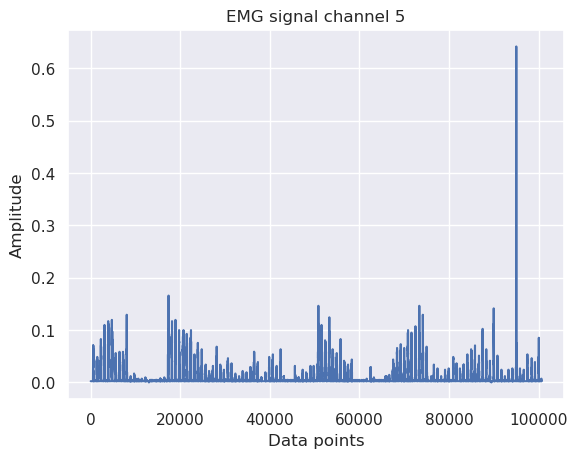

In [5]:
# Plot first channel to get a sense of the data
plt.close("all")
fig, ax = plt.subplots()

EMG_channel = 5

start = 20000
end = 30000

# ax.plot(emg[start:end, EMG_channel])
ax.plot(emg[:, EMG_channel])   
ax.set_title(f"EMG signal channel {EMG_channel}")
ax.set_xlabel("Data points")
ax.set_ylabel("Amplitude")

### Envelop exctraction by applying a moving average

In [6]:
stimulus = data['restimulus']
repetition = data['rerepetition']

print(f'Shape of the data: \nEMG: {emg.shape}, \nStimulus: {stimulus.shape}, \nRepetition: {repetition.shape}')

Shape of the data: 
EMG: (100686, 10), 
Stimulus: (100686, 1), 
Repetition: (100686, 1)


In the paper, it is written that the sEMG signals are sampled at a rate of 2kHz.

In [7]:
# Sampling frequency (Hz)
fs = 2000 

#Time vector for plotting : create evenly spaced time bins from 0 to the total duration of the signal in s
time_steps = np.arange(0,emg.shape[0]/fs, 1/fs)

mov_mean_size to tune

Text(0.5, 0.98, 'EMG envelopes')

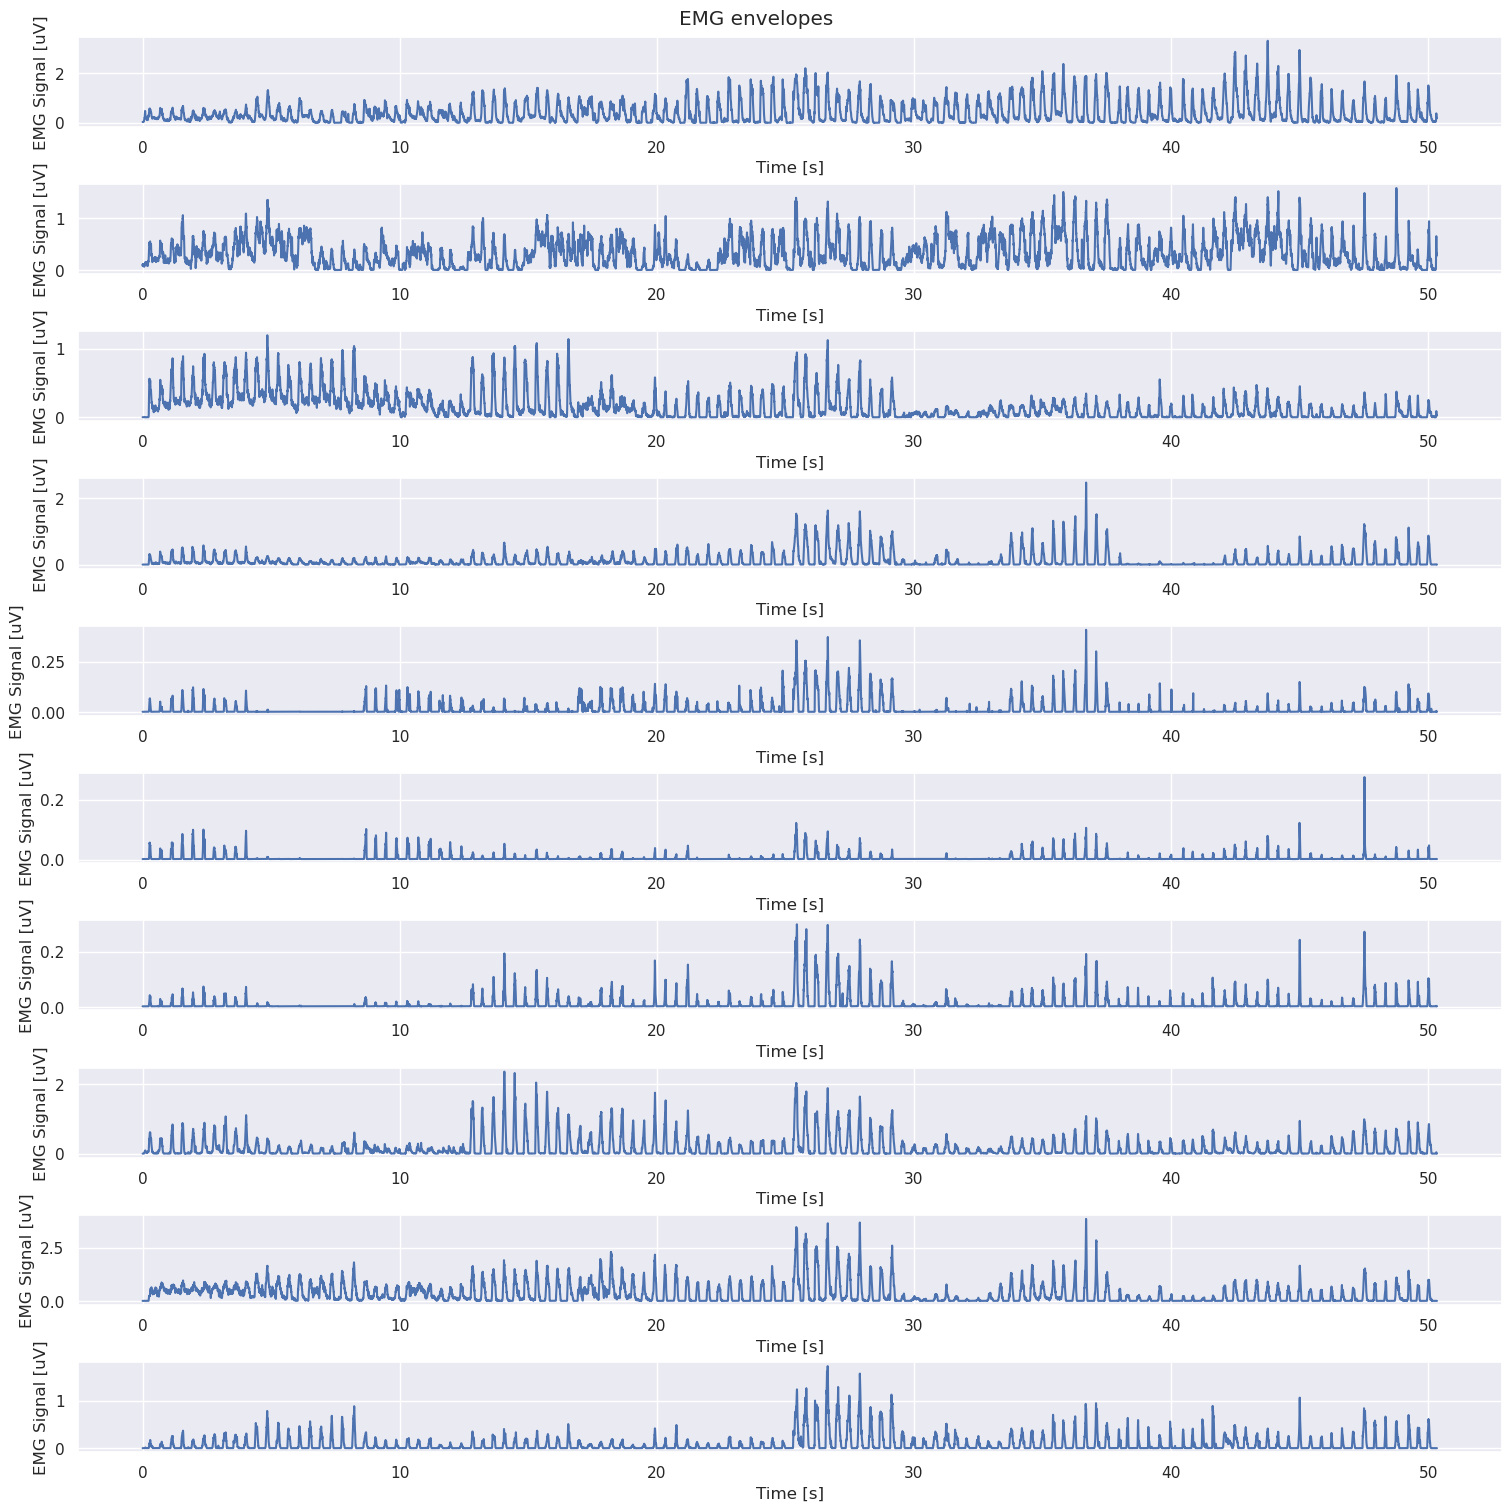

In [11]:
mov_mean_size = 25
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size
emg_envelopes = convolve1d(emg, weights=mov_mean_weights, axis=0) # convolve1d the rectified signal with the moving average weights


fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 15))
for channel_idx in range(n_channels):
    ax[channel_idx].plot(time_steps, emg_envelopes[:, channel_idx])
    ax[channel_idx].set_xlabel("Time [s]")
    ax[channel_idx].set_ylabel("EMG Signal [uV]")
plt.suptitle("EMG envelopes")

In [9]:
# -1 because 0 is the resting condition
n_stimuli = len(np.unique(stimulus)) - 1 
# -1 because 0 is not a repetition
n_repetitions = len(np.unique(repetition)) - 1 

print(f'How many types of movement are there? {n_stimuli}') 
print(f'How many repetitions are there? {n_repetitions}') 

How many types of movement are there? 12
How many repetitions are there? 10


In [10]:
number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        
        idx = np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1)
        number_of_samples_per_trial[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))

number_of_samples_per_trial.shape
number_of_samples_per_trial

array([[307., 390., 262., 226., 418., 204., 196., 270., 306., 489.],
       [334., 323., 344., 309., 333., 376., 362., 307., 348., 339.],
       [465., 352., 450., 460., 436., 389., 323., 388., 383., 316.],
       [310., 402., 357., 396., 255., 333., 263., 369., 438., 471.],
       [516., 382., 425., 379., 463., 411., 387., 343., 286., 377.],
       [337., 319., 337., 368., 338., 336., 268., 354., 319., 313.],
       [428., 392., 341., 393., 421., 445., 342., 328., 329., 358.],
       [289., 372., 406., 397., 498., 336., 415., 328., 472., 405.],
       [384., 424., 371., 316., 280., 314., 342., 284., 307., 421.],
       [311., 296., 299., 296., 301., 246., 213., 317., 493., 221.],
       [352., 403., 338., 416., 330., 355., 313., 322., 329., 219.],
       [270., 330., 300., 387., 295., 204., 363., 267., 281., 329.]])

### Visualization of the data for one single trial

In [12]:
#defining the length of the moving average window
mov_mean_length = 25
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

#initializing the data structure
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = emg[idx, :]
        emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0) 

Text(0.5, 0.98, 'Envelopes of the EMG signal')

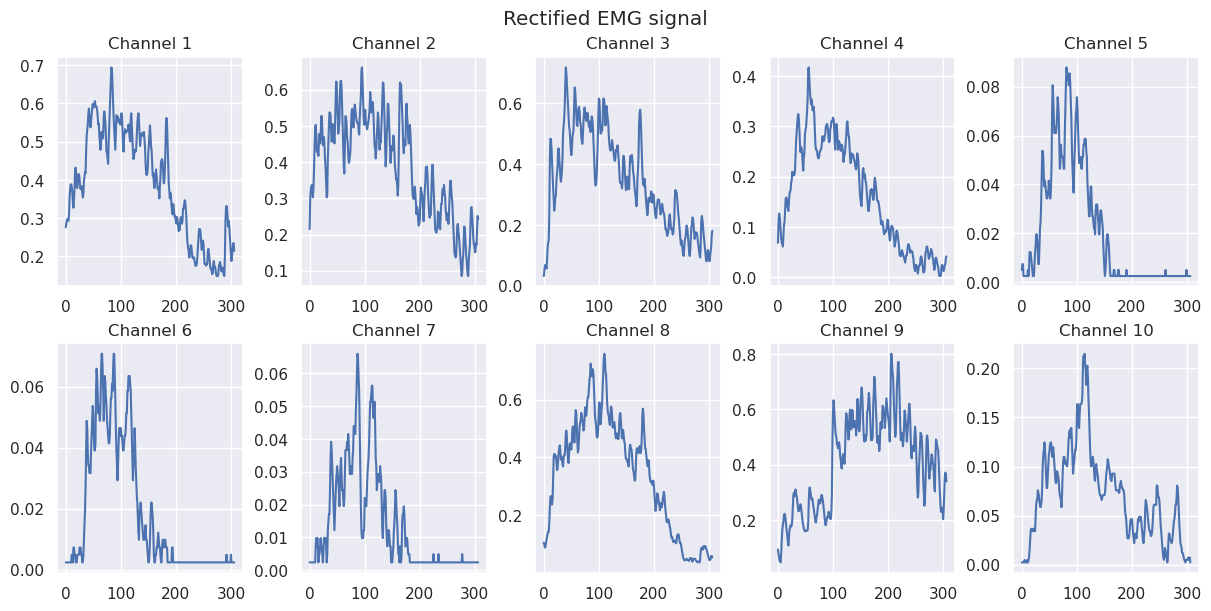

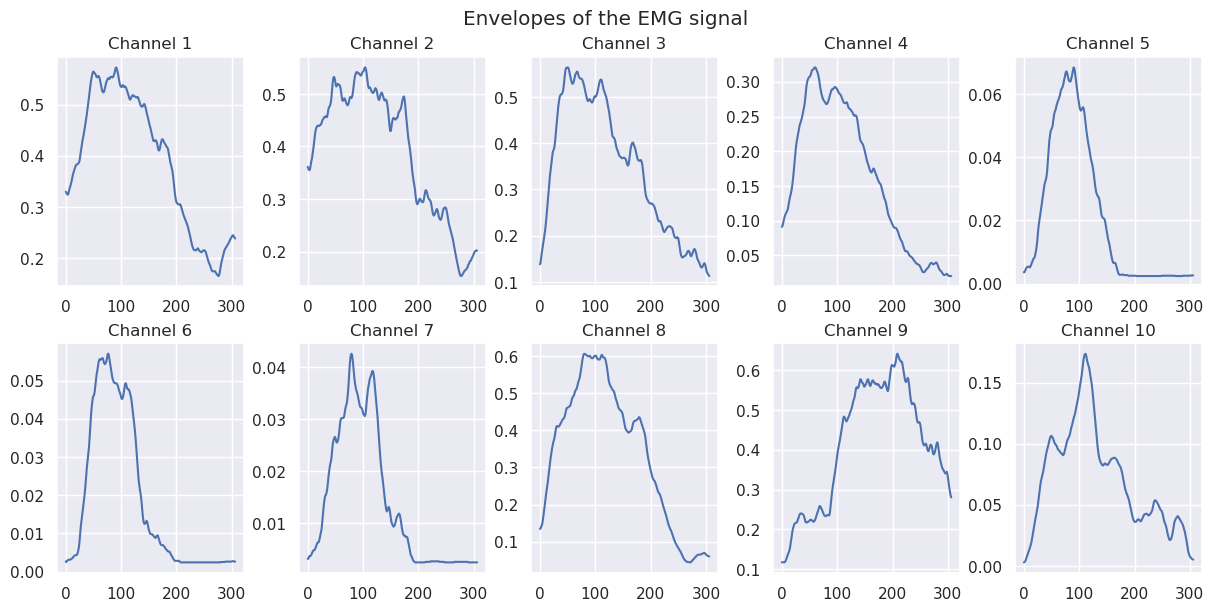

In [15]:
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()

trial_window = emg_windows[6][5]  #Change the indices there to switch between trials  --> first indice : type of movement, second indice : repetition
trial_envelope = emg_envelopes[6][5]  #Change the indices there to switch between trials  --> first indice : type of movement, second indice : repetition

#10 EMG channels
number_of_emg_channels = emg.shape[-1]
# plot Rectified EMG signal
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])   
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal")

# plot Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True)
ax = ax.ravel()
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])   
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal")

Plotting of the different channels on the same y-scale, to see the importance of each relativ to the other ones

Text(0.5, 0.98, 'Envelopes of the EMG signal')

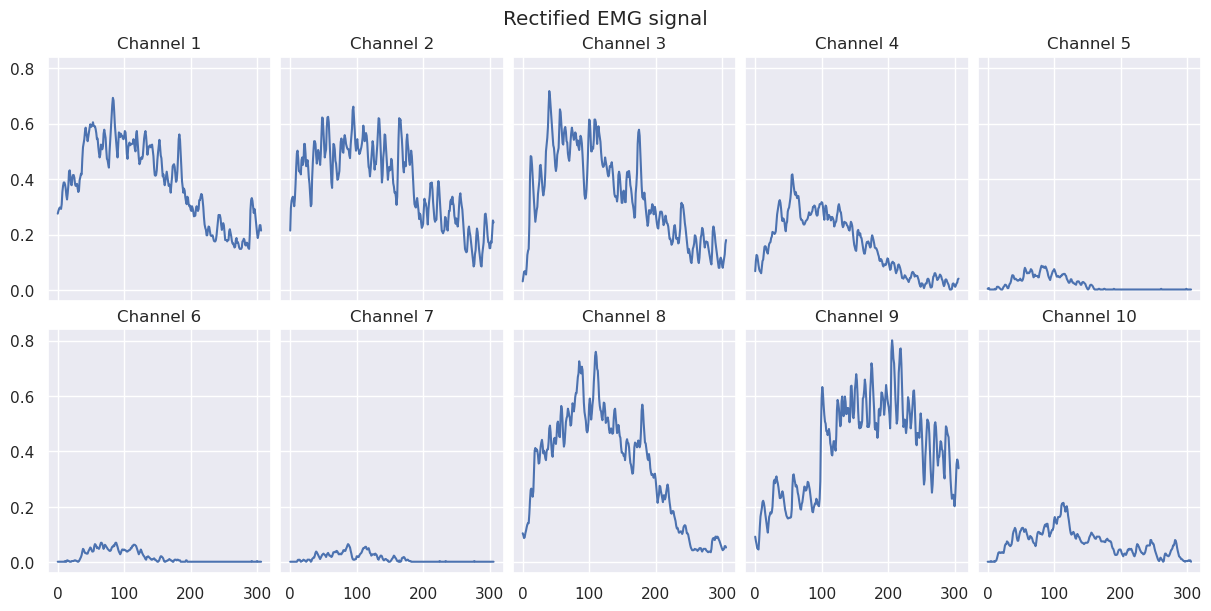

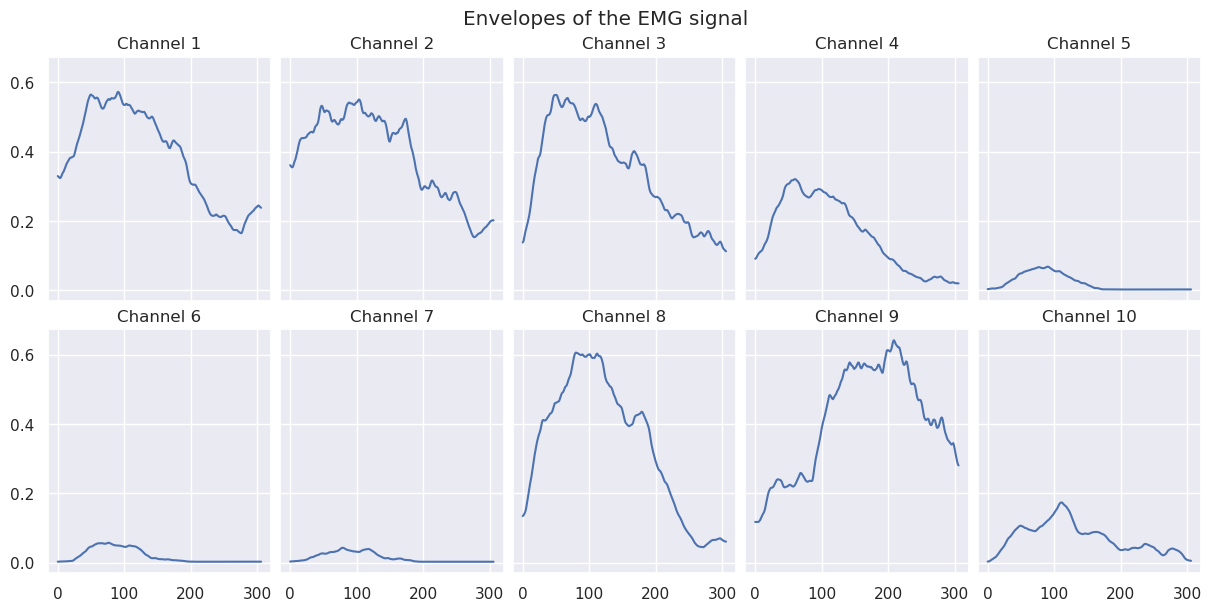

In [16]:
# Now we plot all the channels on the same y-scale
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

number_of_emg_channels = emg.shape[-1]
# plot Rectified EMG signal
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])   
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal")

# plot Envelopes of the EMG signal
fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()
for channel_idx in range(number_of_emg_channels): 
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Envelopes of the EMG signal")

### Visualizing across repetitions

In [17]:
emg_average_activations = np.zeros((n_channels, n_stimuli, n_repetitions))
for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        #mean across time for each channel
        emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelopes[stimuli_idx][repetition_idx], axis=0) 

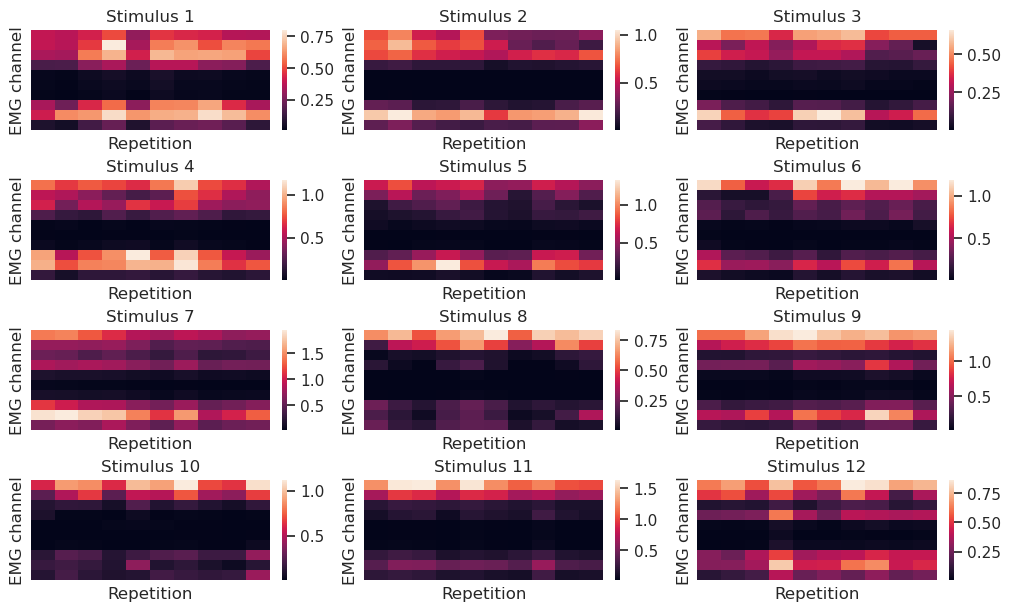

In [18]:
fig, ax = plt.subplots(4, 3, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

for stimuli_idx in range(n_stimuli):
    sns.heatmap(np.squeeze(emg_average_activations[:, stimuli_idx, :]), ax=ax[stimuli_idx] ,xticklabels=False, yticklabels=False, cbar = True)
    ax[stimuli_idx].title.set_text("Stimulus " + str(stimuli_idx + 1))
    ax[stimuli_idx].set_xlabel("Repetition")
    ax[stimuli_idx].set_ylabel("EMG channel")

Résultats à analyser: Does the data look reasonable? Did you need to remove any trials?
Channels 5,6 and 7 seem a lot less active than the others

## Feature exctraction and visualization

### Extract features and build the dataset for classification 

In [19]:
def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions
    
    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)
    
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result
                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1
            
    # Return the constructed dataset and corresponding labels
    return dataset, labels

In [20]:
# Define the features 

# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)
# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)
# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
# Slope sign changes (SSC)
ssc = lambda x: np.sum((np.diff(x, axis=0)[:-1, :] * np.diff(x, axis=0)[1:, :]) < 0, axis=0)

#Feel free to add more features, e.g. frequency domain features. (See https://doi.org/10.3390/s19204596 and https://doi.org/10.1088/0967-3334/24/2/307)


dataset, labels = build_dataset_from_ninapro(
    emg=emg,
    stimulus=stimulus,
    repetition=repetition,
    #features=[mav, std]
    features=[mav, std, maxav, rms, wl, ssc] # Uncomment this line to use all features once implemented
)

print(f"dataset dimension: {dataset.shape}")
print(f"labels dimension: {labels.shape}")

dataset dimension: (120, 60)
labels dimension: (120,)


### Visualization of the features

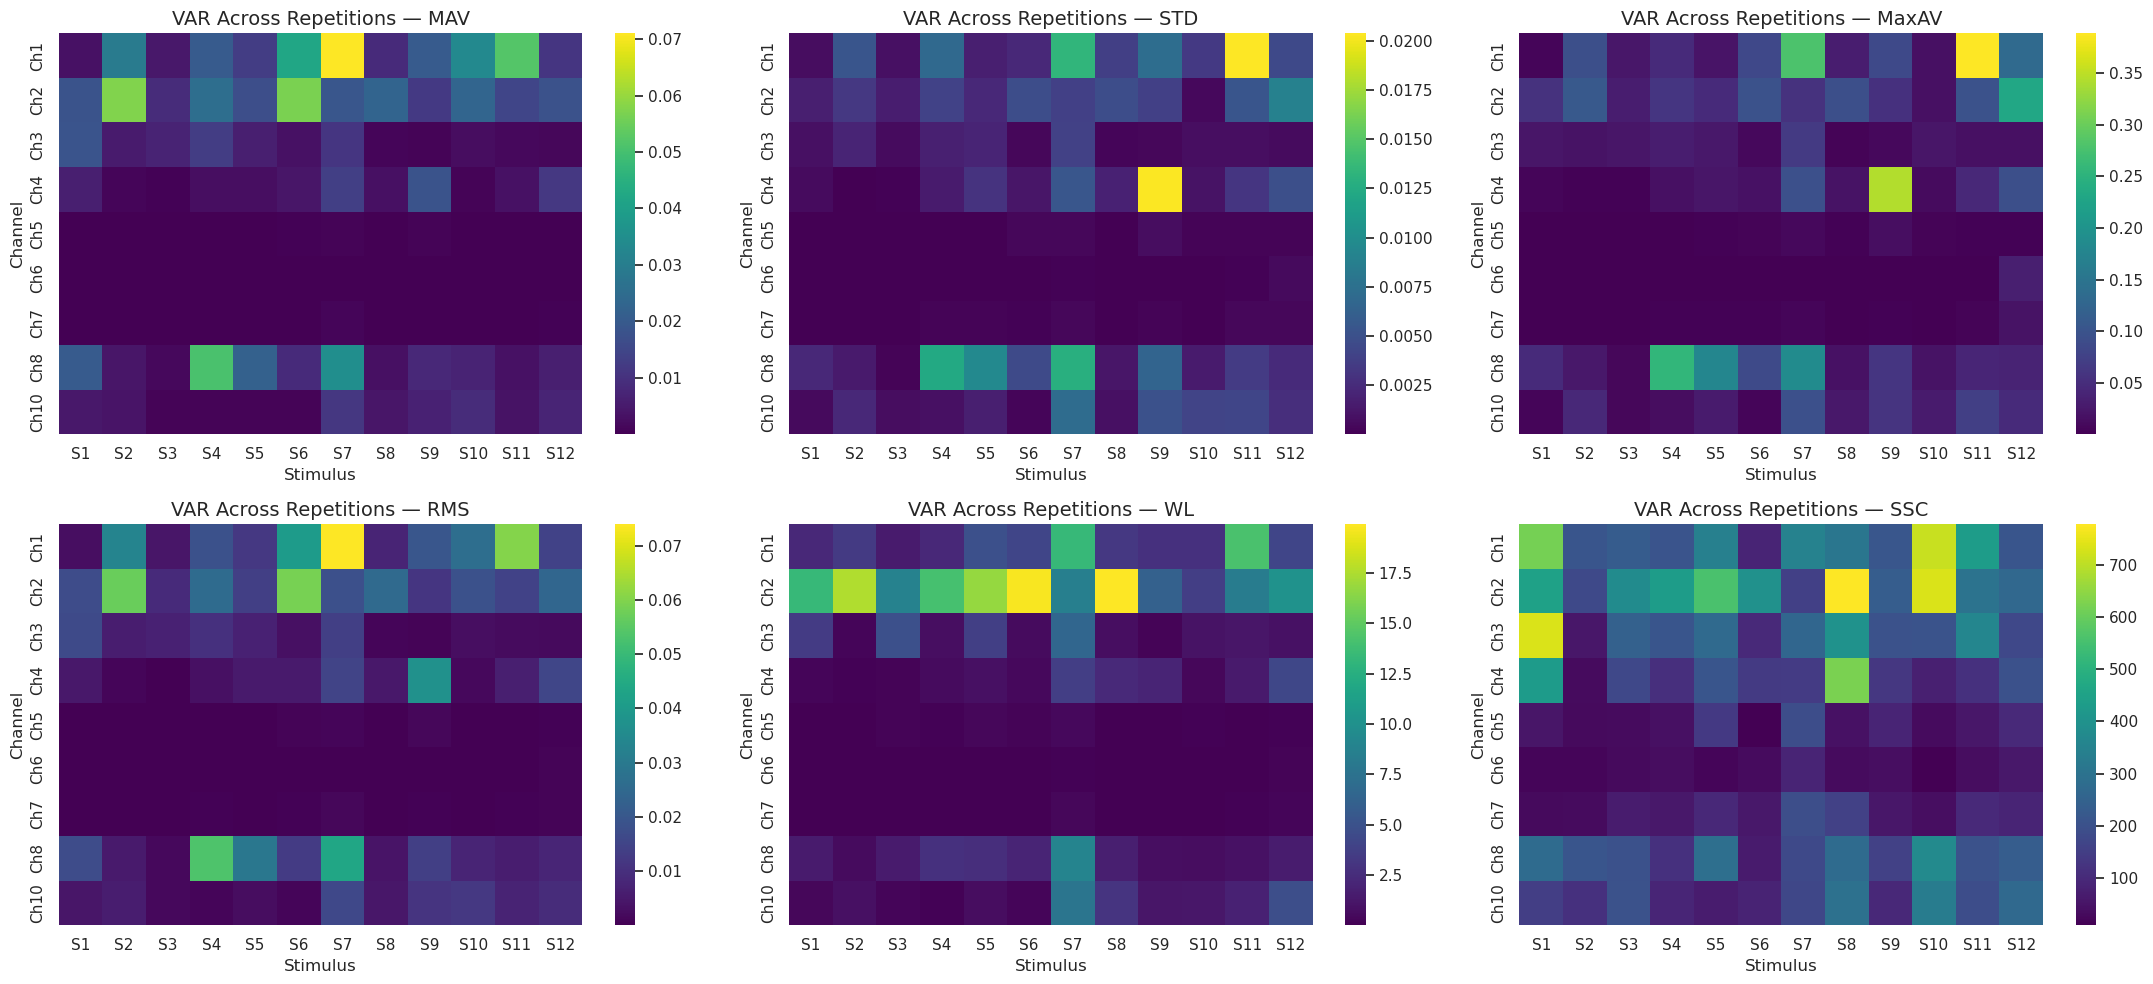

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

features = {
    "MAV": mav,
    "STD": std,
    "MaxAV": maxav,
    "RMS": rms,
    "WL": wl,
    "SSC": ssc
}

# -------- Identifying stimuli and repetitions --------
stimuli = np.unique(stimulus)
stimuli = stimuli[stimuli != 0]
reps = np.unique(repetition)
reps = reps[reps != 0]

# Remove channel 9 (index=8)
channels_to_use = [i for i in range(emg.shape[1]) if i != 8]
n_channels = len(channels_to_use)

# Slice EMG to remove channel 9
emg_used = emg[:, channels_to_use]

# -------- Compute variance of each feature across repetitions --------

variance_maps = {}

for fname, func in features.items():
    var_matrix = np.zeros((n_channels, len(stimuli)))

    for s_i, stim_val in enumerate(stimuli):
        feature_values_per_rep = np.zeros((len(reps), n_channels))

        for r_i, rep_val in enumerate(reps):
            mask = np.logical_and(stimulus == stim_val, repetition == rep_val).squeeze()
            segment = emg_used[mask, :]

            if segment.size > 0:
                feature_values_per_rep[r_i, :] = func(segment)
            else:
                feature_values_per_rep[r_i, :] = np.nan

        # variance across repetitions
        var_matrix[:, s_i] = np.nanvar(feature_values_per_rep, axis=0)

    variance_maps[fname] = var_matrix

# -------- Plot 6 heatmaps --------

fig, axes = plt.subplots(2, 3, figsize=(22, 10))
axes = axes.flatten()

for ax, (fname, mat) in zip(axes, variance_maps.items()):
    sns.heatmap(
        mat,
        ax=ax,
        cmap="viridis",
        xticklabels=[f"S{int(s)}" for s in stimuli],
        yticklabels=[f"Ch{channels_to_use[c]+1}" for c in range(n_channels)],
        cbar=True
    )
    ax.set_title(f"VAR Across Repetitions — {fname}", fontsize=14)
    ax.set_xlabel("Stimulus")
    ax.set_ylabel("Channel")

plt.tight_layout()
plt.show()


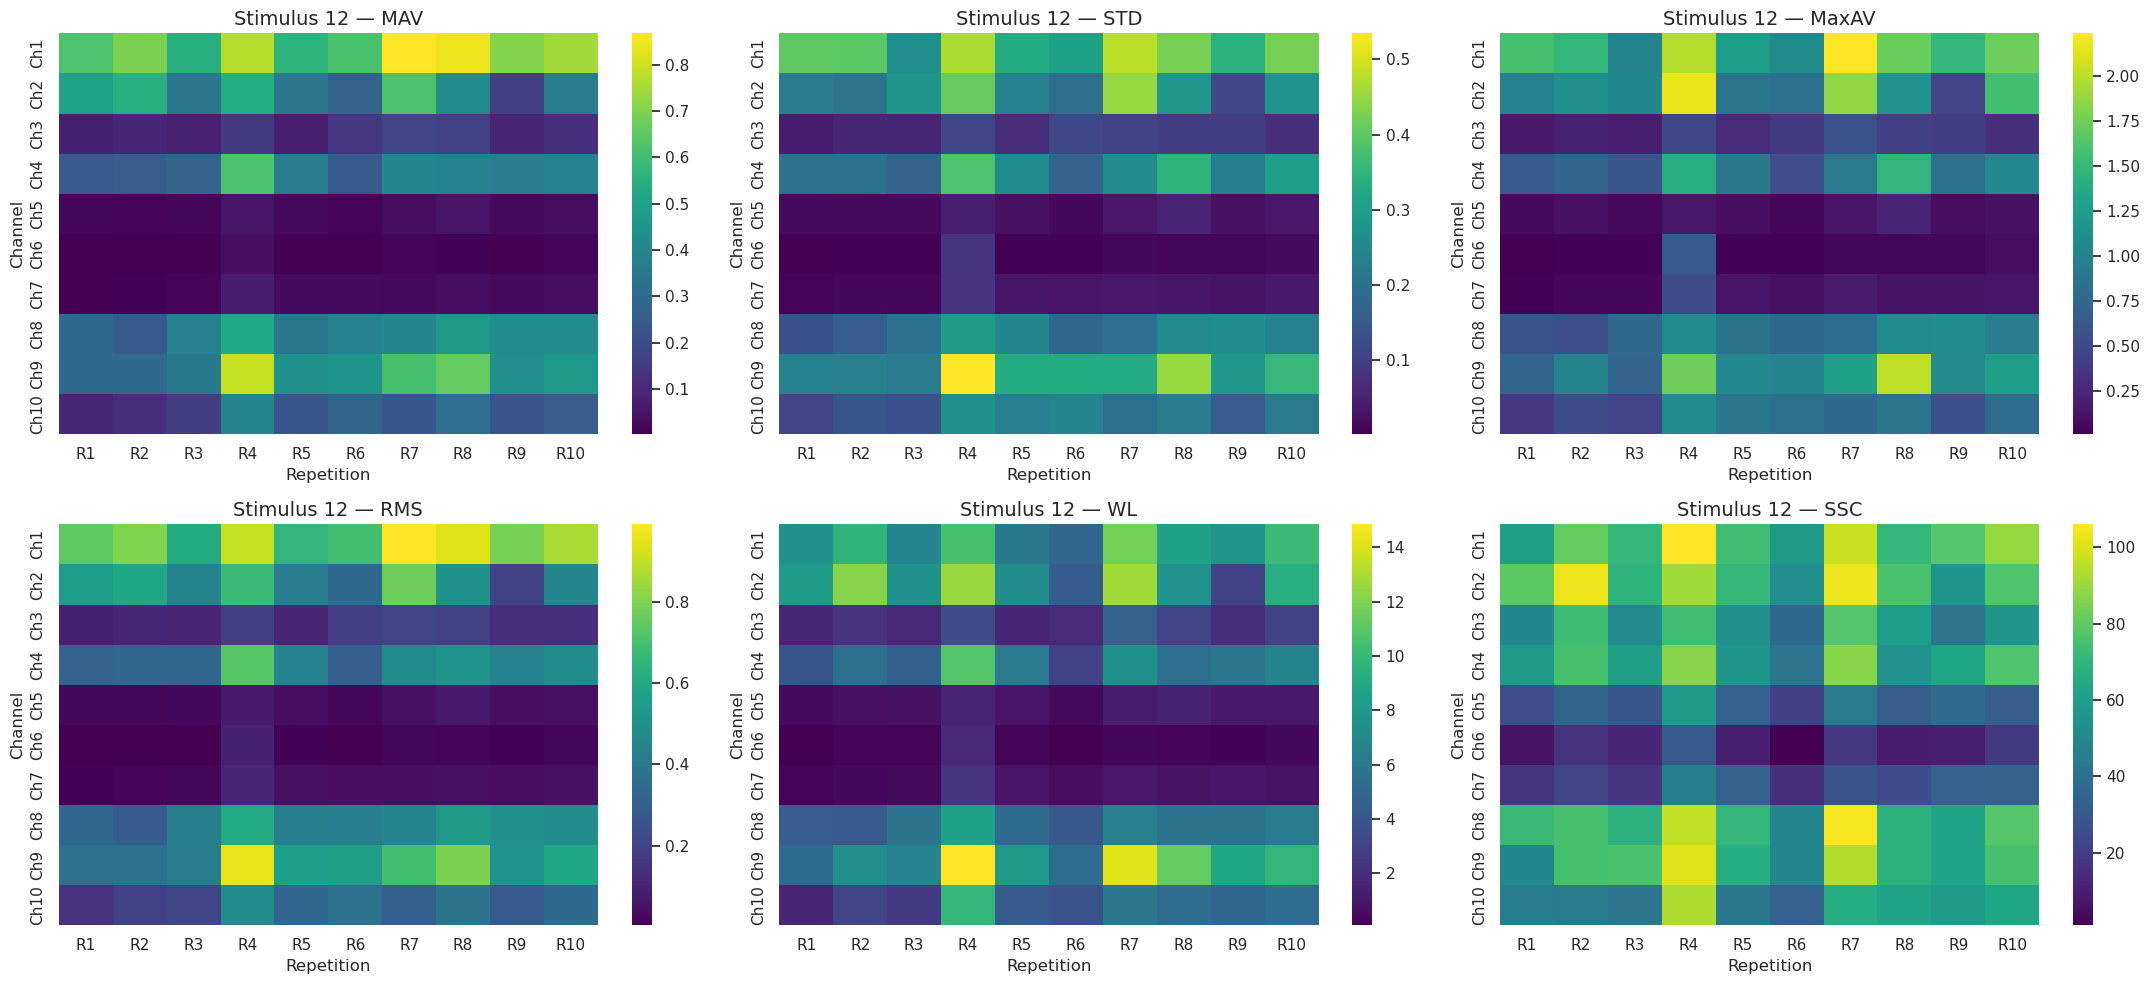

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --------- Prepare axes ---------
stim_to_plot = 12
reps = np.unique(repetition)
reps = reps[reps != 0]
n_reps = len(reps)
n_channels = emg.shape[1]

fig, axes = plt.subplots(2, 3, figsize=(22, 10))
axes = axes.flatten()

# --------- Loop over features ---------
for ax, (fname, func) in zip(axes, features.items()):

    heatmap_data = np.zeros((n_channels, n_reps))

    for r_i, rep in enumerate(reps):

        mask = np.logical_and(stimulus == stim_to_plot, repetition == rep).squeeze()
        segment = emg[mask, :]

        if segment.size > 0:
            heatmap_data[:, r_i] = func(segment)
        else:
            heatmap_data[:, r_i] = np.nan

    sns.heatmap(
        heatmap_data,
        ax=ax,
        cmap="viridis",
        cbar=True,
        xticklabels=[f"R{int(r)}" for r in reps],
        yticklabels=[f"Ch{c+1}" for c in range(n_channels)]
    )

    ax.set_title(f"Stimulus {stim_to_plot} — {fname}", fontsize=14)
    ax.set_xlabel("Repetition")
    ax.set_ylabel("Channel")

plt.tight_layout()
plt.show()


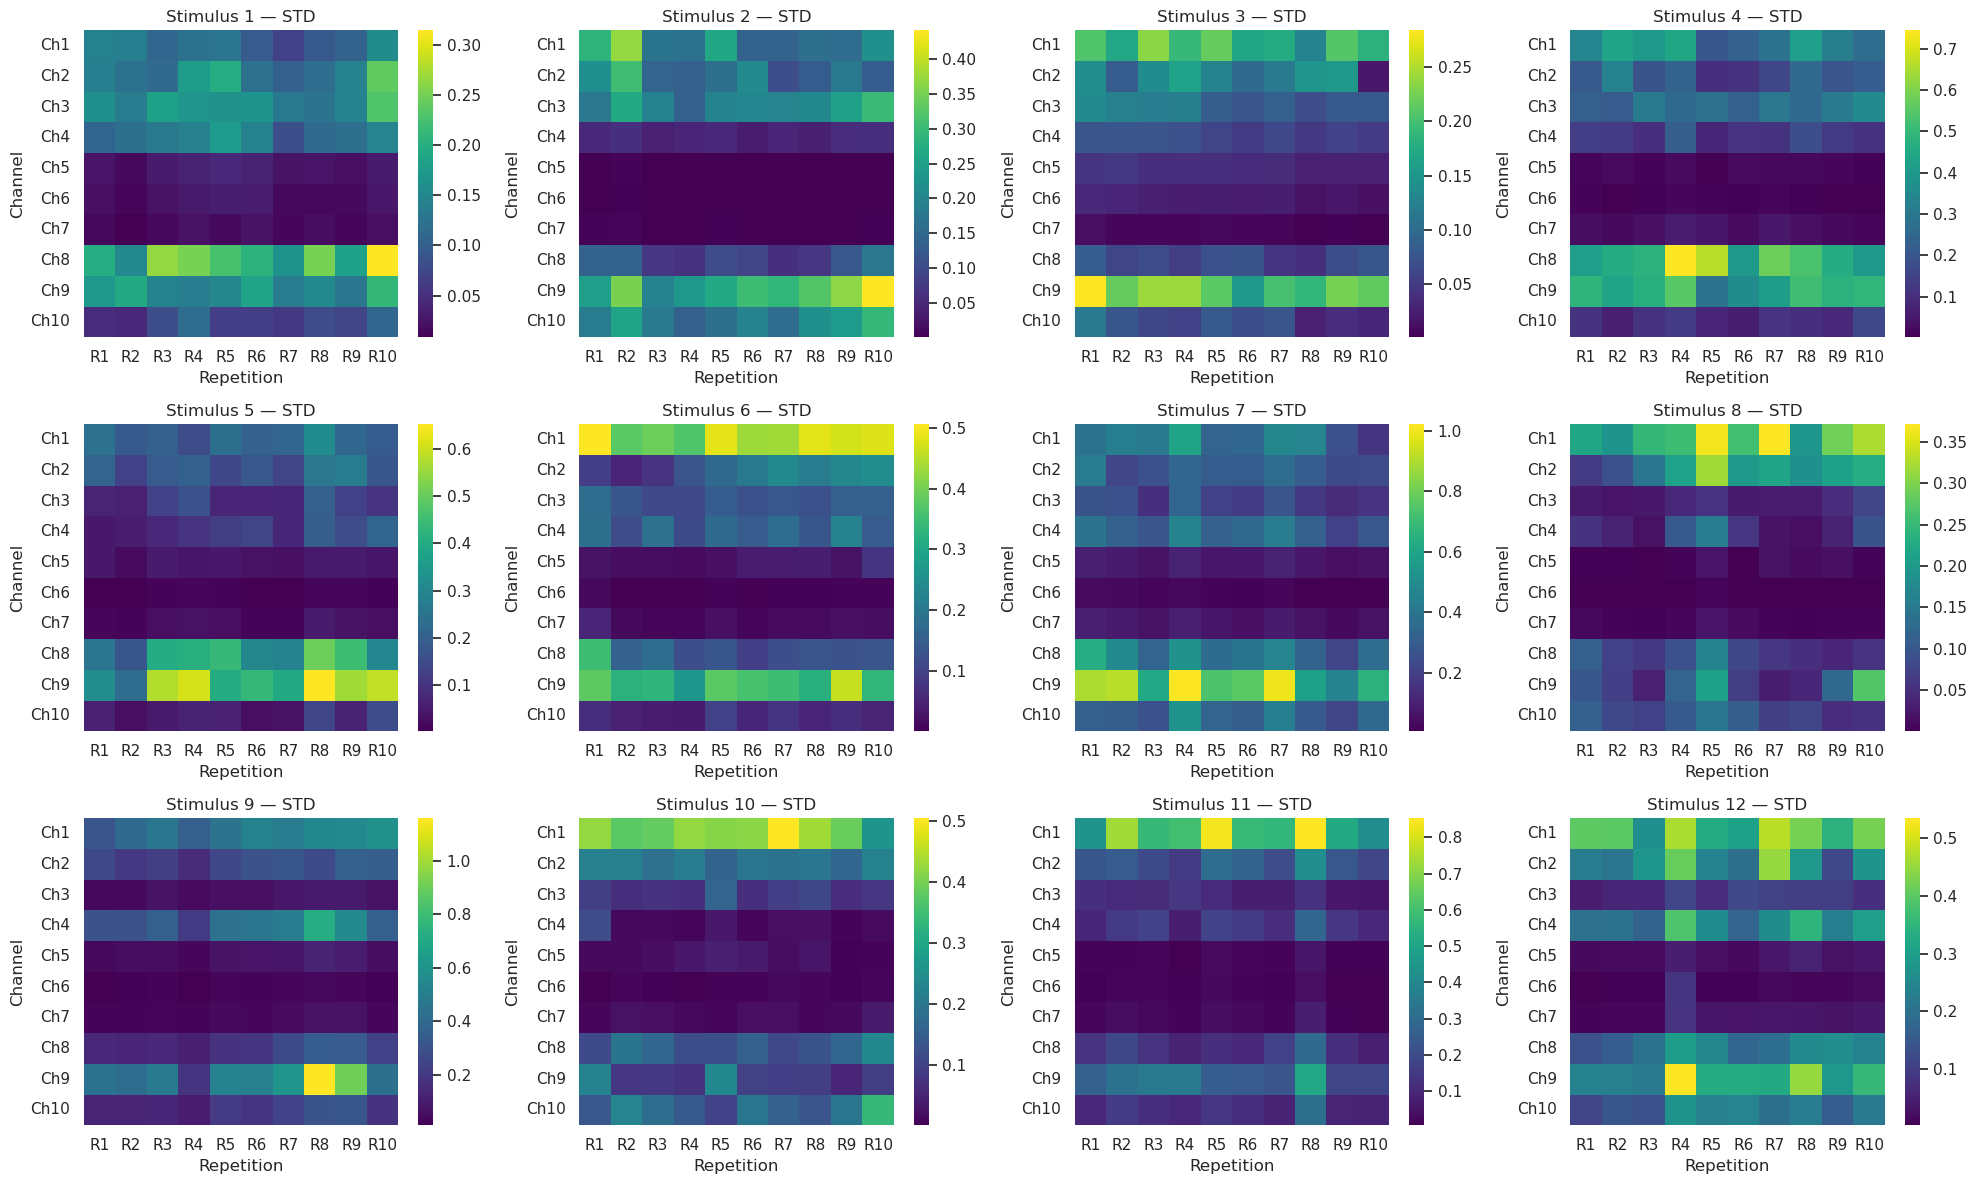

In [156]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----- Your SSC feature -----
ssc = lambda x: np.sum((np.diff(x, axis=0)[:-1, :] * np.diff(x, axis=0)[1:, :]) < 0, axis=0)

# ----- Identify number of stimuli and repetitions -----
stimuli = np.unique(stimulus)
stimuli = stimuli[stimuli != 0]  # remove resting class 0
reps = np.unique(repetition)
reps = reps[reps != 0]

n_stimuli = len(stimuli)
n_reps = len(reps)
n_channels = emg.shape[1]

# ----- Prepare the figure: 12 heatmaps -----
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
axes = axes.flatten()

for idx, stim in enumerate(stimuli):
    # Create matrix: channels × repetitions
    heatmap_data = np.zeros((n_channels, n_reps))
    
    for r_i, rep in enumerate(reps):
        # select timepoints for this stimulus & repetition
        mask = np.logical_and(stimulus == stim, repetition == rep).squeeze()
        emg_seg = emg[mask, :]
        
        if emg_seg.size > 0:
            heatmap_data[:, r_i] = std(emg_seg)
        else:
            heatmap_data[:, r_i] = np.nan

    ax = axes[idx]
    sns.heatmap(
        heatmap_data,
        ax=ax,
        cmap="viridis",
        cbar=True,
        xticklabels=[f"R{r}" for r in reps],
        yticklabels=[f"Ch{c+1}" for c in range(n_channels)]
    )

    ax.set_title(f"Stimulus {stim} — STD")
    ax.set_xlabel("Repetition")
    ax.set_ylabel("Channel")

plt.tight_layout()
plt.show()


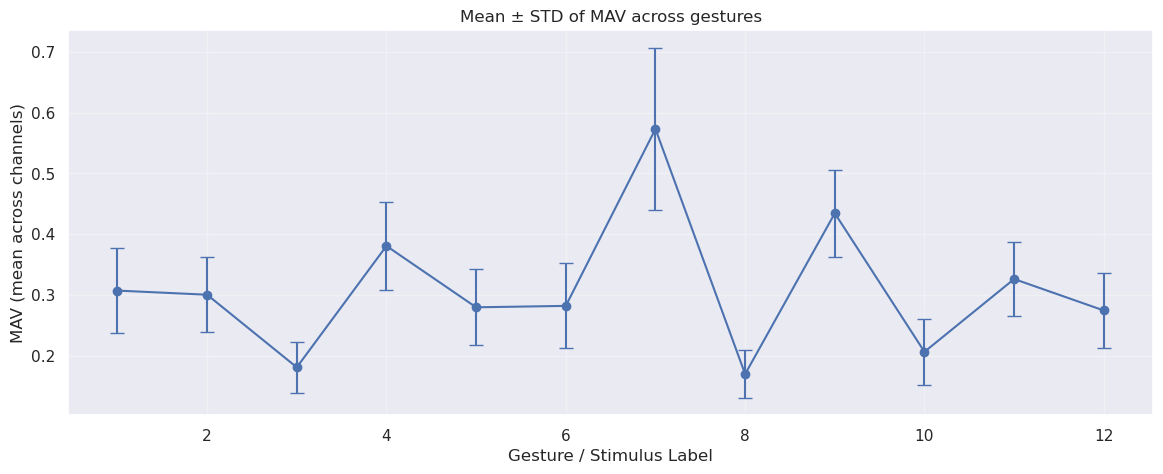

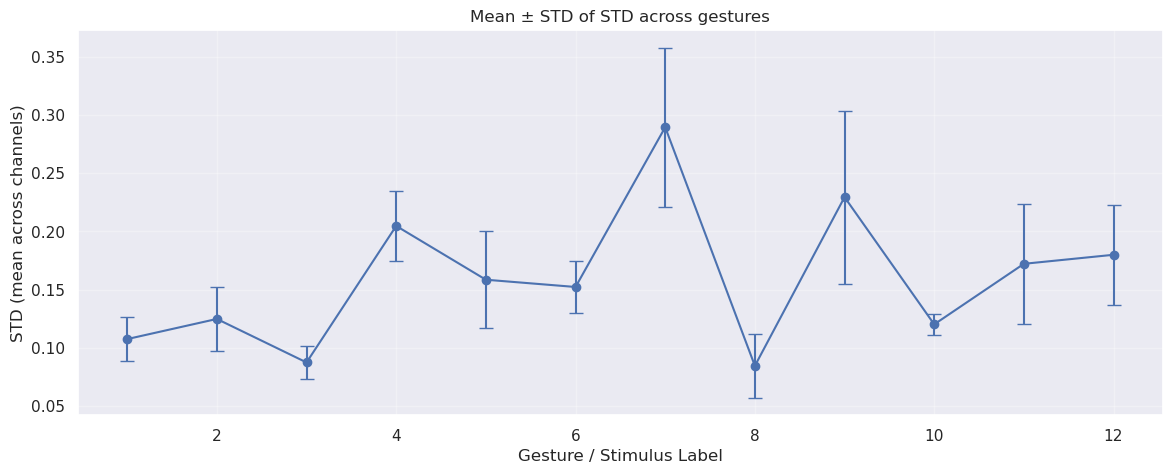

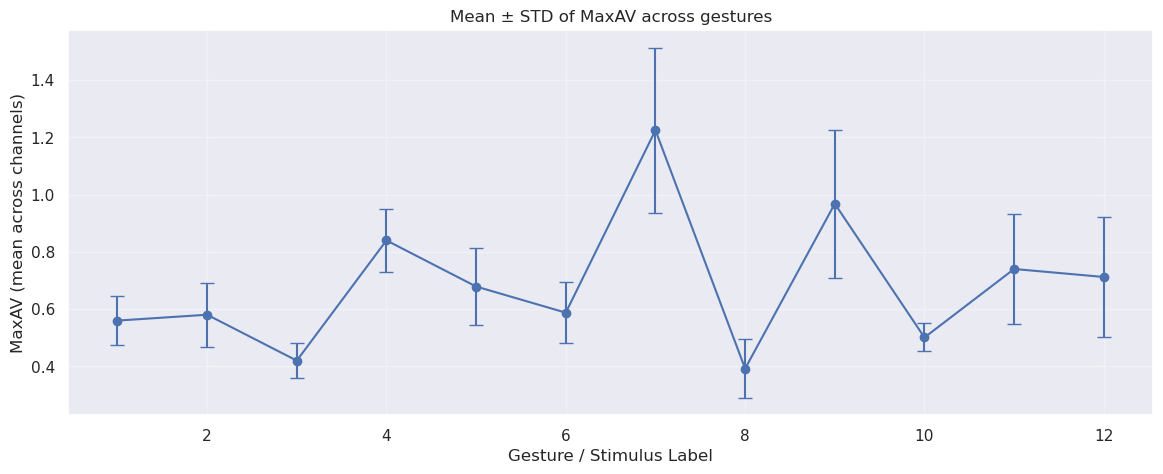

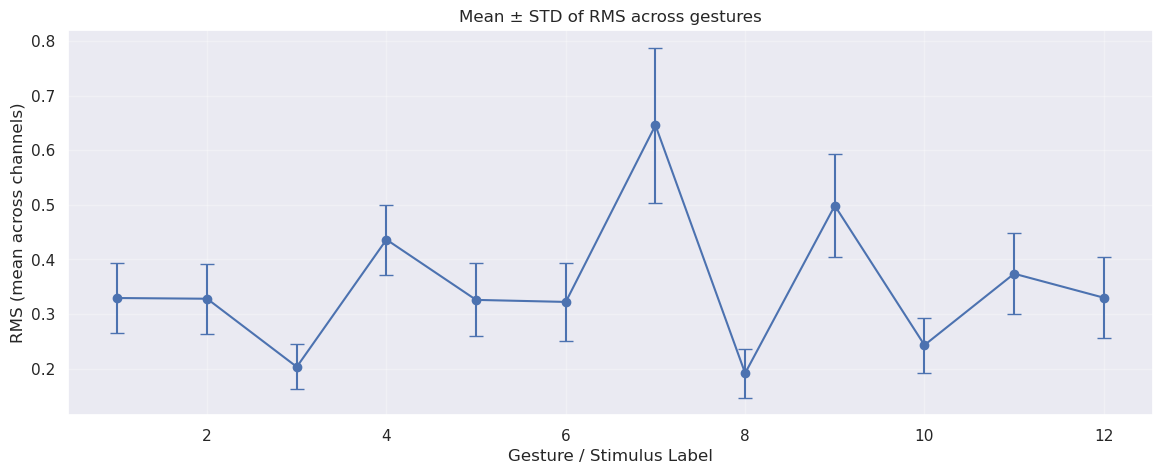

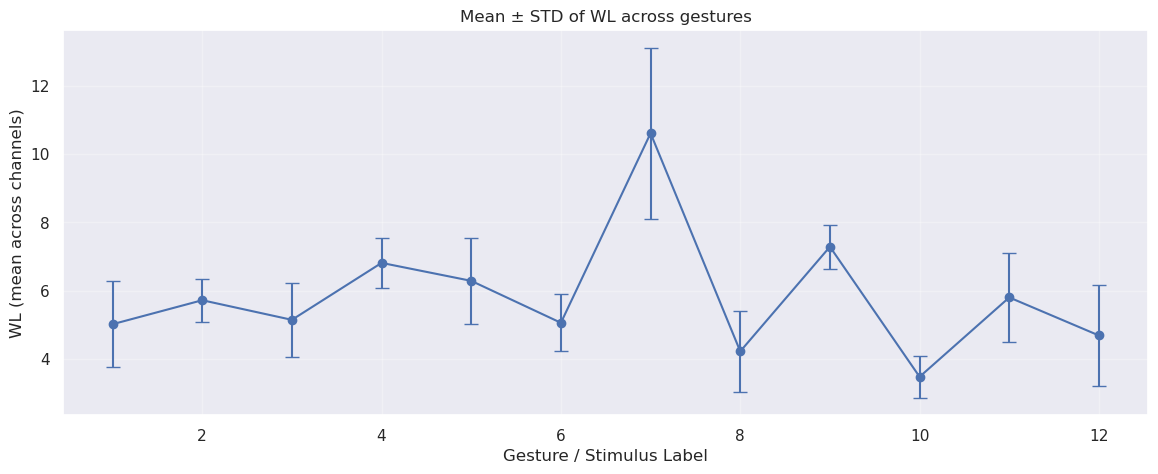

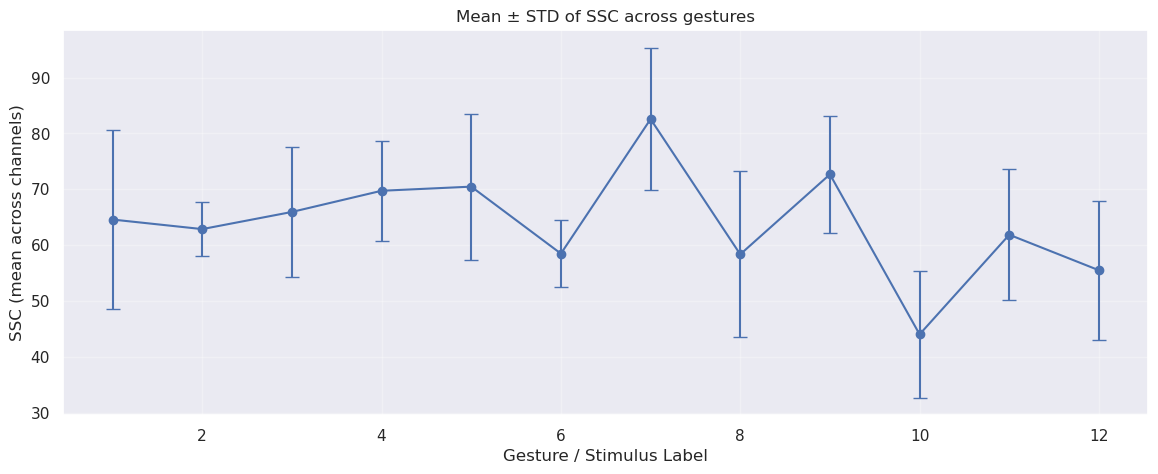

In [147]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Number of EMG channels
n_channels = emg.shape[1]

# Feature names (must match the order used in your dataset builder)
feature_names = ["MAV", "STD", "MaxAV", "RMS", "WL", "SSC"]

# Expand feature names to channel-level: e.g. MAV_ch1, MAV_ch2, ...
all_feature_labels = []
for fname in feature_names:
    all_feature_labels.extend([f"{fname}_ch{ch+1}" for ch in range(n_channels)])

# Convert dataset to a DataFrame for easy plotting
df = pd.DataFrame(dataset, columns=all_feature_labels)
df["label"] = labels.astype(int)

# ------------------------------------------------------------
# Mean ± STD plot of each feature per gesture (per-channel avg)
# ------------------------------------------------------------

for fname in feature_names:
    feature_cols = [col for col in df.columns if col.startswith(fname)]
    # average across channels within each feature
    df[f"{fname}_mean"] = df[feature_cols].mean(axis=1)

    means = df.groupby("label")[f"{fname}_mean"].mean()
    stds  = df.groupby("label")[f"{fname}_mean"].std()

    plt.figure(figsize=(14, 5))
    plt.errorbar(means.index, means.values, yerr=stds.values, fmt='o-', capsize=5)
    plt.title(f"Mean ± STD of {fname} across gestures")
    plt.xlabel("Gesture / Stimulus Label")
    plt.ylabel(f"{fname} (mean across channels)")
    plt.grid(True, alpha=0.3)
    plt.show()


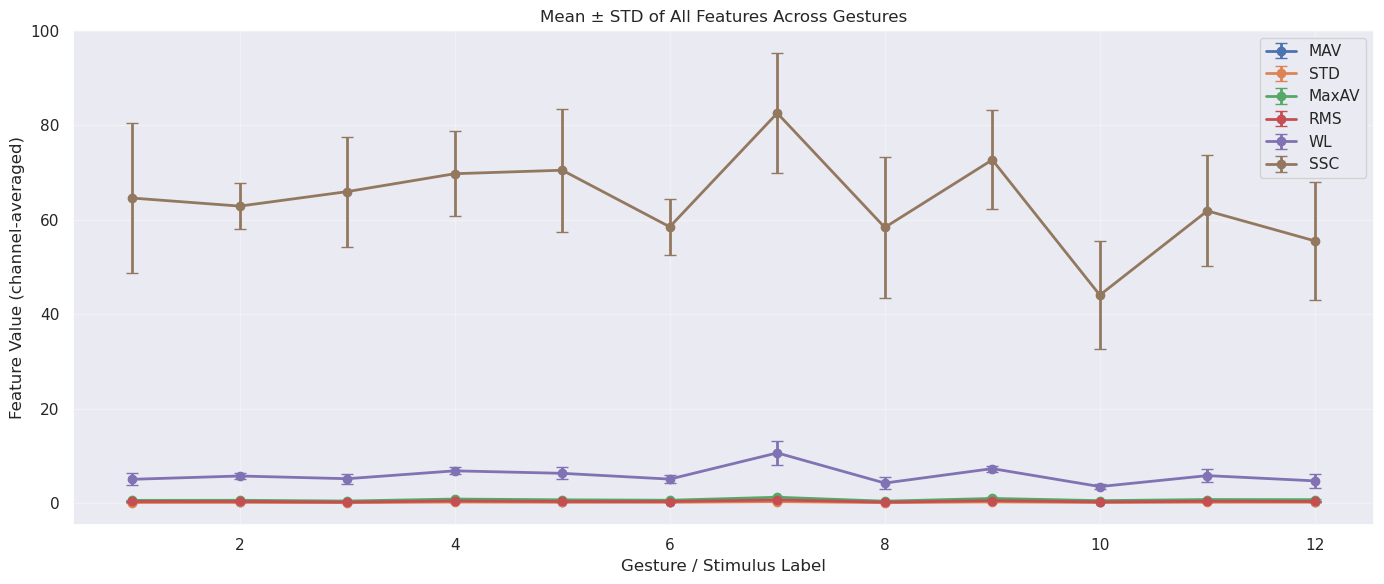

In [148]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Number of EMG channels
n_channels = emg.shape[1]

# Feature names in the same order used during feature extraction
feature_names = ["MAV", "STD", "MaxAV", "RMS", "WL", "SSC"]

# Expand feature names to channel-level
all_feature_labels = []
for fname in feature_names:
    all_feature_labels.extend([f"{fname}_ch{ch+1}" for ch in range(n_channels)])

# Convert to DataFrame
df = pd.DataFrame(dataset, columns=all_feature_labels)
df["label"] = labels.astype(int)

# ---------------------------------------------------------
# Compute per-feature mean across channels + per-gesture stats
# ---------------------------------------------------------

feature_means = {}
feature_stds = {}

for fname in feature_names:
    cols = [c for c in df.columns if c.startswith(fname)]
    df[f"{fname}_mean"] = df[cols].mean(axis=1)

    feature_means[fname] = df.groupby("label")[f"{fname}_mean"].mean()
    feature_stds[fname]  = df.groupby("label")[f"{fname}_mean"].std()

# ---------------------------------------------------------
# Make ONE plot with all features
# ---------------------------------------------------------

plt.figure(figsize=(14, 6))

for fname in feature_names:
    means = feature_means[fname]
    stds = feature_stds[fname]

    plt.errorbar(
        means.index, means.values, yerr=stds.values,
        fmt='-o', capsize=4, linewidth=2, label=fname
    )

plt.title("Mean ± STD of All Features Across Gestures")
plt.xlabel("Gesture / Stimulus Label")
plt.ylabel("Feature Value (channel-averaged)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## Classification

Now that we have created the dataset, we need to split it into training, validation and testing data.

Accuracy score: 0.7931034482758621


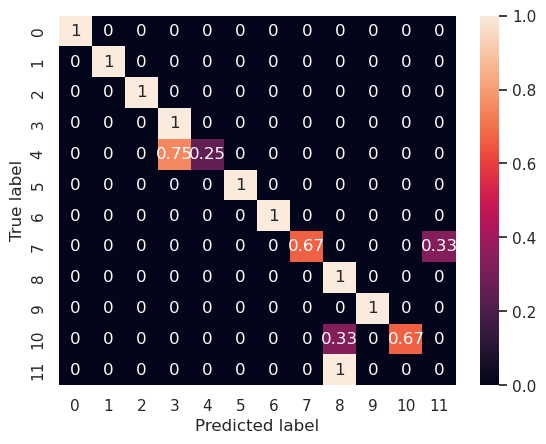

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Split the dataset into training and testing sets
# Here, 30% of the data is reserved for testing, and 70% is used for training
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2)

# The training set now needs to be further split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

# Normalizing the data
# StandardScaler is used to scale the features so that they have a mean of 0 and a standard deviation of 1
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)  # Fit the scaler on the training data and transform it
X_val_z = scaler.transform(X_val)        # Transform the test data using the same scaler
X_test_z = scaler.transform(X_test)


clf = RandomForestClassifier()
clf.fit(X_train_z, y_train)

# Evaluate the classifier on the test set
# Predict the labels for the test set
y_pred = clf.predict(X_val_z)
# Calculate the accuracy of the model
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy score: {accuracy}")

# Create a confusion matrix to visualize the performance of the classification
# The confusion matrix shows the true vs predicted labels
confmat = confusion_matrix(y_val, y_pred, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)  # Use seaborn to create a heatmap of the confusion matrix
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label");

lets do some cross-validation!

In [24]:
# perform cross-validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_train_z, y_train, cv=5)
print(f"Accuracy scores of all models: {scores}")
print(f"Mean accuracy across all models: {np.mean(scores)}")

/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Accuracy scores of all models: [0.92857143 0.92857143 0.84615385 0.76923077 0.92307692]
Mean accuracy across all models: 0.8791208791208792


Hyperparameter optimization seems like a good idea as well

In [25]:
# use cross validation to find the best hyperparameters for SVC

from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [60,70, 80 ,90,100,110,120,130,140],
    "max_features": ['sqrt', 'log2', ],
}

grid = GridSearchCV(RandomForestClassifier(), param_grid)
grid.fit(X_train_z, y_train)

print(f"Best estimator: {grid.best_estimator_}")
print(f"Best hyperparameters: {grid.best_params_}")

y_pred = grid.predict(X_val_z)

accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy score of best model: {accuracy}")

/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best estimator: RandomForestClassifier(max_features='log2', n_estimators=130)
Best hyperparameters: {'max_features': 'log2', 'n_estimators': 130}
Accuracy score of best model: 0.8275862068965517


## Feature Selection / Dimensionnality reduction

### Method 1: 

Estimated mutual information between each feature and the target:
 [0.55305463 0.19057324 0.73744453 0.83928223 0.80587485 0.6152576
 0.60389886 0.57443939 0.91892731 0.5638373  0.73052134 0.26230443
 0.6775811  0.82438645 0.62002208 0.63460669 0.60304    0.70522033
 0.84897307 0.51579297 0.58271424 0.16143629 0.57643355 0.8051942
 0.54339492 0.55470049 0.50212254 0.64192599 0.85333237 0.50775731
 0.64425442 0.25717566 0.73499109 0.89186976 0.77290916 0.65018414
 0.63619979 0.68792805 0.99091783 0.53170848 0.41504217 0.03544645
 0.70179831 0.90672607 0.80750321 0.81889825 0.59695373 0.5774482
 0.79533539 0.54622517 0.11604524 0.03472547 0.21297042 0.4765684
 0.70242965 0.65408018 0.51368287 0.3101012  0.42447881 0.28575859]

Accuracy score of a model with k best features: 0.6206896551724138


Text(0.5, 19.049999999999997, 'Predicted label')

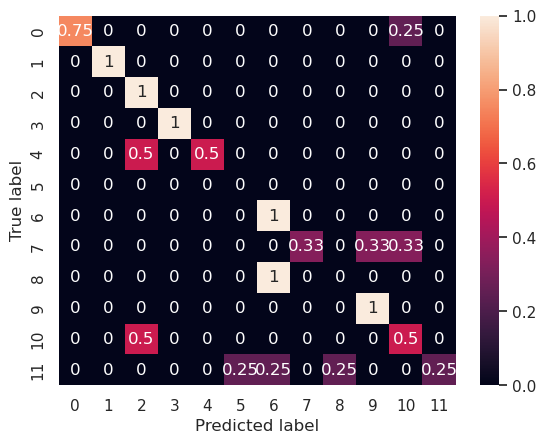

In [103]:
# Import necessary functions for feature selection
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

# Calculate mutual information between each feature and the target variable.
# Mutual information is a measure of the dependency between variables.
# A higher value indicates a stronger relationship.
mutual_info = mutual_info_classif(X_train_z, y_train)
print(f"Estimated mutual information between each feature and the target:\n {mutual_info}\n")

# Select the top 10 features based on mutual information scores.
# Note: You can change 'k' to 30 if you are working with more features.
k_best = SelectKBest(mutual_info_classif, k=10)
k_best.fit(X_train_z, y_train)

# Transform the training and test datasets to only include the selected features.
X_train_best = k_best.transform(X_train_z)
X_val_best = k_best.transform(X_val_z)

clf = RandomForestClassifier(**grid.best_params_) # use the best parameters found before, You can also perform another round of grid search with the new features
clf.fit(X_train_best, y_train)

# Predict the labels for the test set using the trained model.
y_pred = clf.predict(X_val_best)

# Calculate the accuracy of the model with the selected features.
# Accuracy is the ratio of correctly predicted instances to the total instances.
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy score of a model with k best features: {accuracy}")

# Create a confusion matrix to visualize the performance of the classification model.
# The confusion matrix shows the true vs predicted labels.
confmat = confusion_matrix(y_val, y_pred, normalize="true")

# Plot the confusion matrix using a heatmap for better visualization.
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")

 ### Method 2 : 

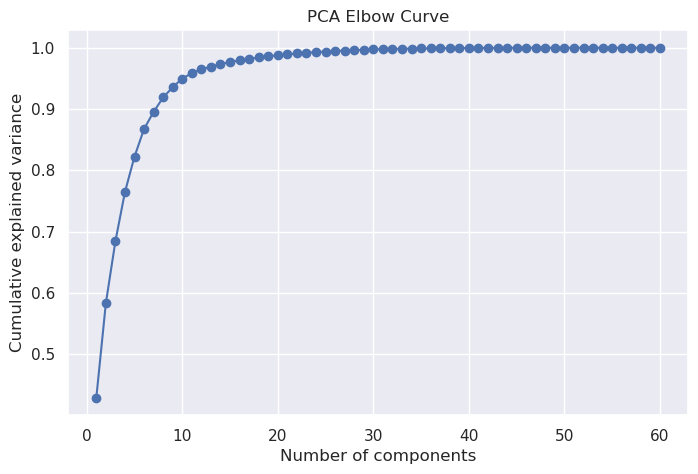

In [33]:
from sklearn.decomposition import PCA

# We already have the standardized data (X_train_z, X_val_z, X_test_z)

n_components = X_train_z.shape[1]
pca_test = PCA(n_components=n_components)
pca_test.fit(X_train_z)

explained_var = np.cumsum(pca_test.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(range(1, n_features+1), explained_var, marker='o')
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA Elbow Curve")
plt.grid(True)
plt.show()

Reduce the number of components

Number of components to reach 95% variance: 7
67


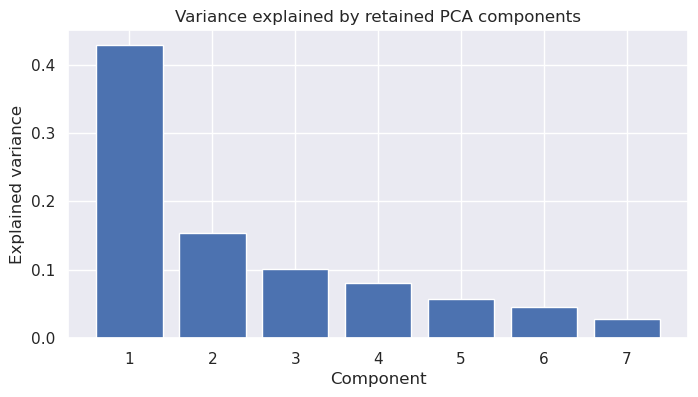

In [71]:
n_components_reduced = np.argmax(cum_exp_var >= 0.89) + 1
print("Number of components to reach 95% variance:", n_components_reduced)

# Fit PCA with chosen number of components
pca = PCA(n_components=n_components_reduced)
X_train_pca = pca.fit_transform(X_train_z)
X_val_pca   = pca.transform(X_val_z)
X_test_pca  = pca.transform(X_test_z)

# Visualize relativ importance of each components kept
plt.figure(figsize=(8,4))
plt.bar(range(1, n_components_reduced+1), pca.explained_variance_ratio_)
plt.xlabel("Component")
plt.ylabel("Explained variance")
plt.title("Variance explained by retained PCA components")
plt.grid(True)
plt.show()

In [67]:
# Classification
clf = RandomForestClassifier(**grid.best_params_) # use the best parameters found before, You can also perform another round of grid search with the new features
clf.fit(X_train_pca, y_train)
y_pred_pca = clf.predict(X_test_pca)

# Performance Evaluation
acc_pca = accuracy_score(y_test, y_pred_pca)
print(f"Test accuracy with PCA: {acc_pca:.3f}")

Test accuracy with PCA: 0.792


-------------------------- TESTs POUR VERIFIER QUE TOUS LES TRIALS SONT OK ---------------------------------- PAS SURE QU'IL FAUT GARDER CA 
!

In [44]:
def check_trial_quality(signal):
    # signal shape = (time, channels)
    
    problems = []
    
    # Canal constant (toujours 0 ou quasi 0)
    if np.any(np.std(signal, axis=0) < 1e-4):
        problems.append("Canal constant (possiblement débranché)")
    
    # Saturation (valeurs proches du max)
    if np.any(np.max(signal, axis=0) > 5):
        problems.append("Saturation (clipping)")
    
    # Très faible variance → bruit faible, problème possible
    if np.mean(np.std(signal, axis=0)) < 0.01:
        problems.append("Faible variance globale")
        
    return problems


bad_trials = []

for s in range(n_stimuli):
    for r in range(n_repetitions):
        sig = emg_windows[s][r]
        issues = check_trial_quality(trial)
        if len(issues) > 0:
            bad_trials.append((s+1, r+1, issues))

bad_trials


[]

In [45]:
bad_trials = []  # liste des trials problématiques

for s in range(n_stimuli):
    for r in range(n_repetitions):

        signal = emg_windows[s][r]    # trial (temps × channels)

        issues = check_trial_quality(signal)

        if len(issues) > 0:
            bad_trials.append({
                "stimulus": s+1,
                "repetition": r+1,
                "problems": issues
            })


In [46]:
for entry in bad_trials:
    print(f"Stimulus {entry['stimulus']:2d}, "
          f"Répétition {entry['repetition']:2d}  →  {entry['problems']}")


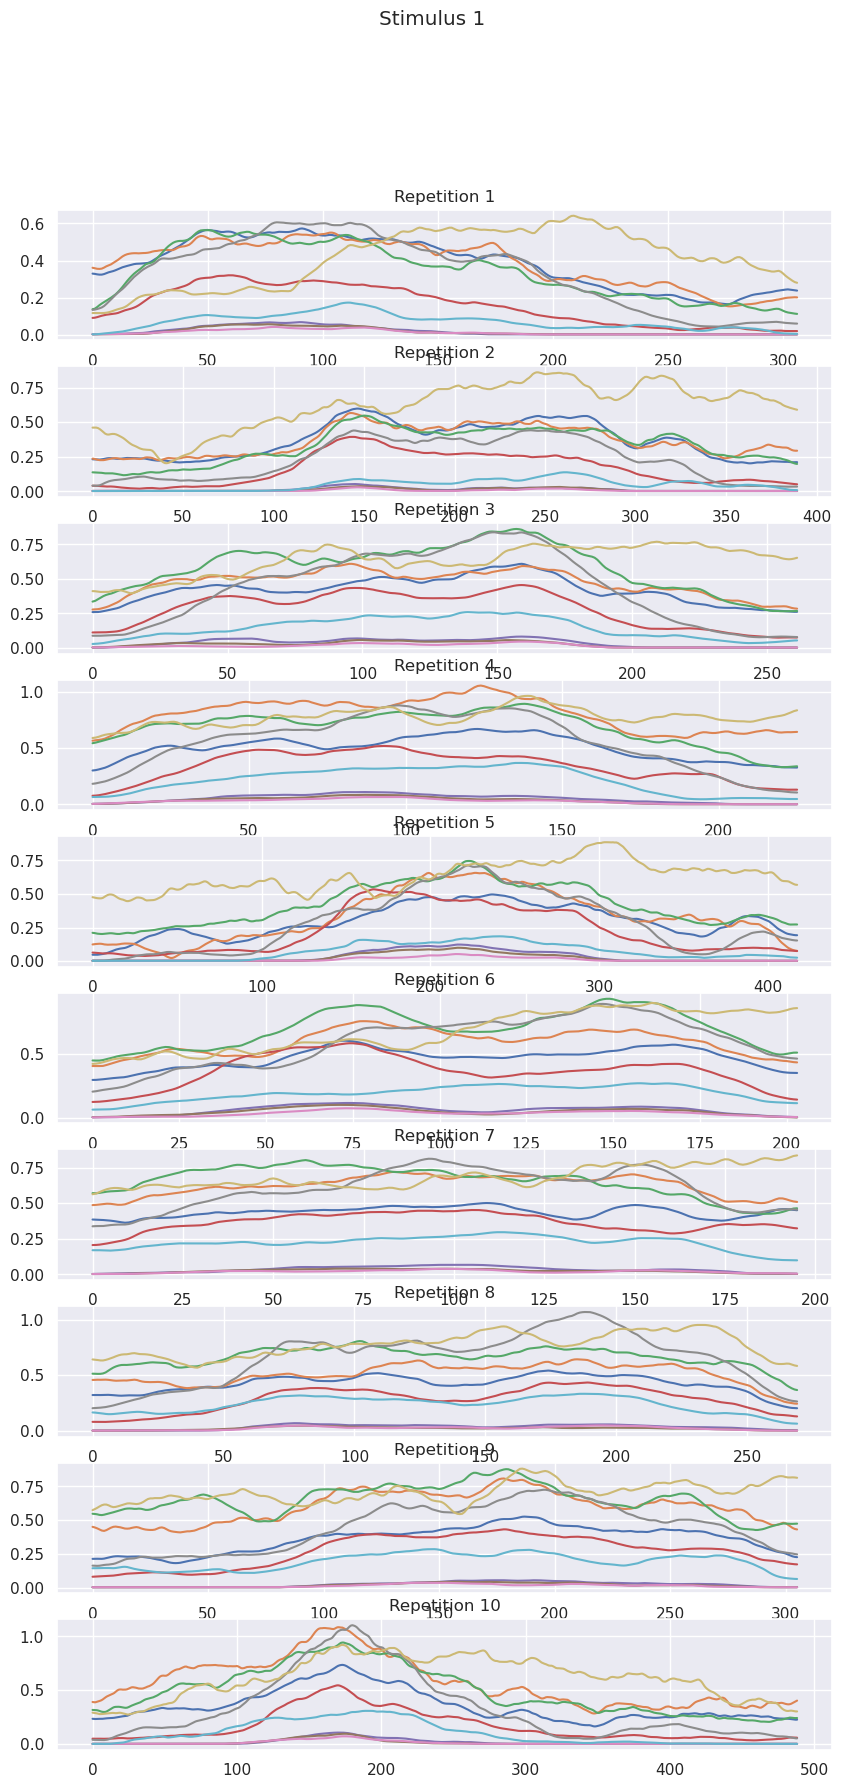

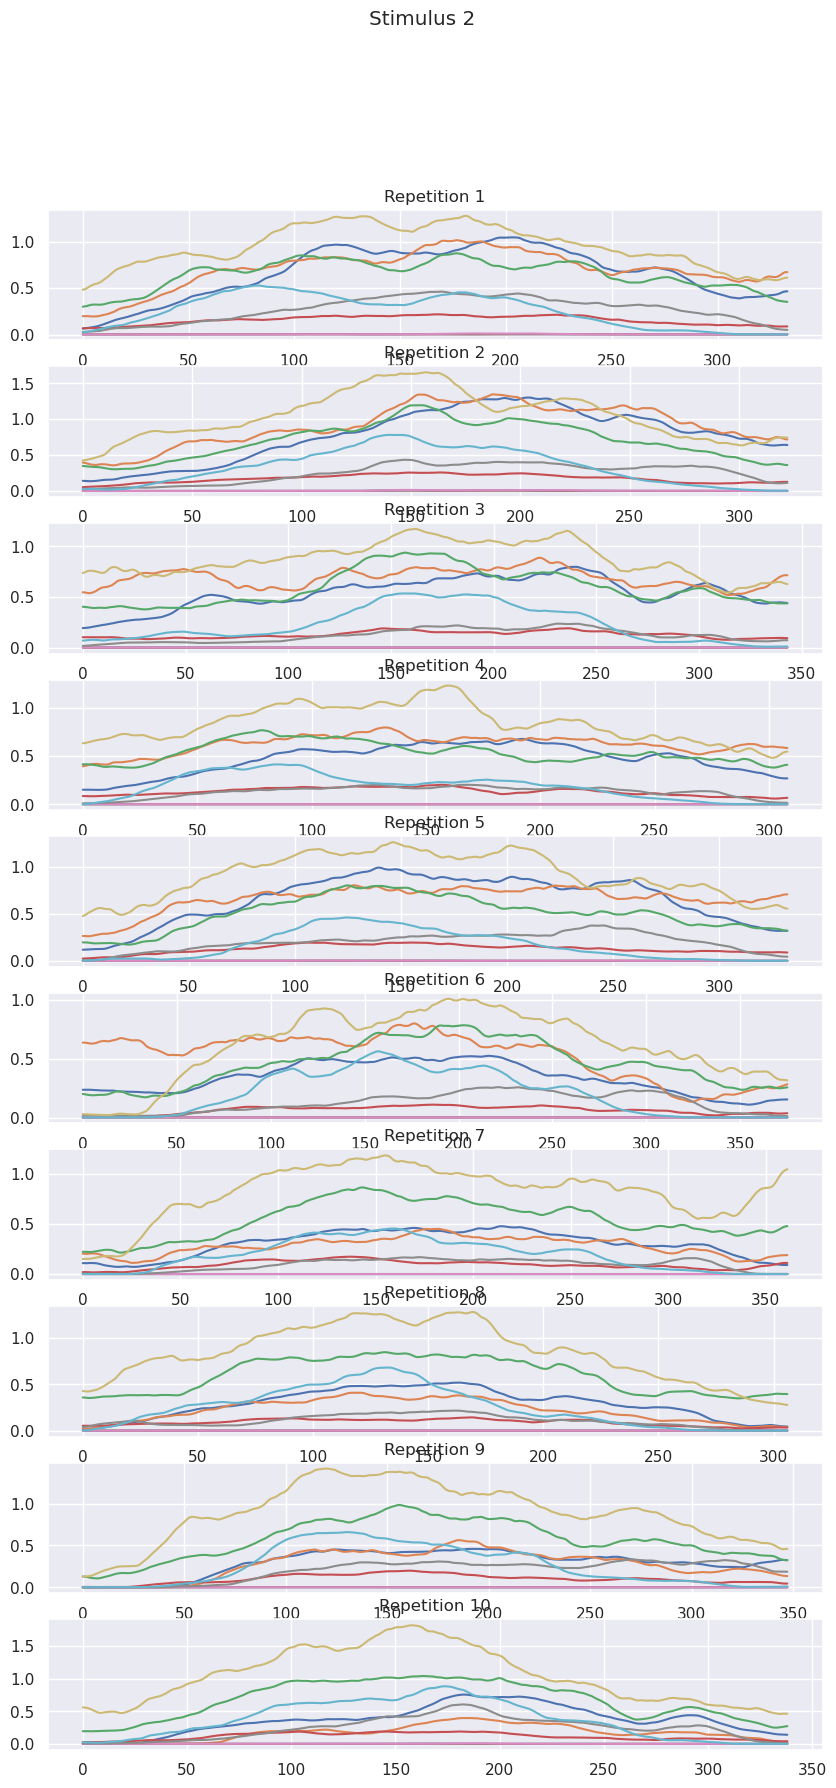

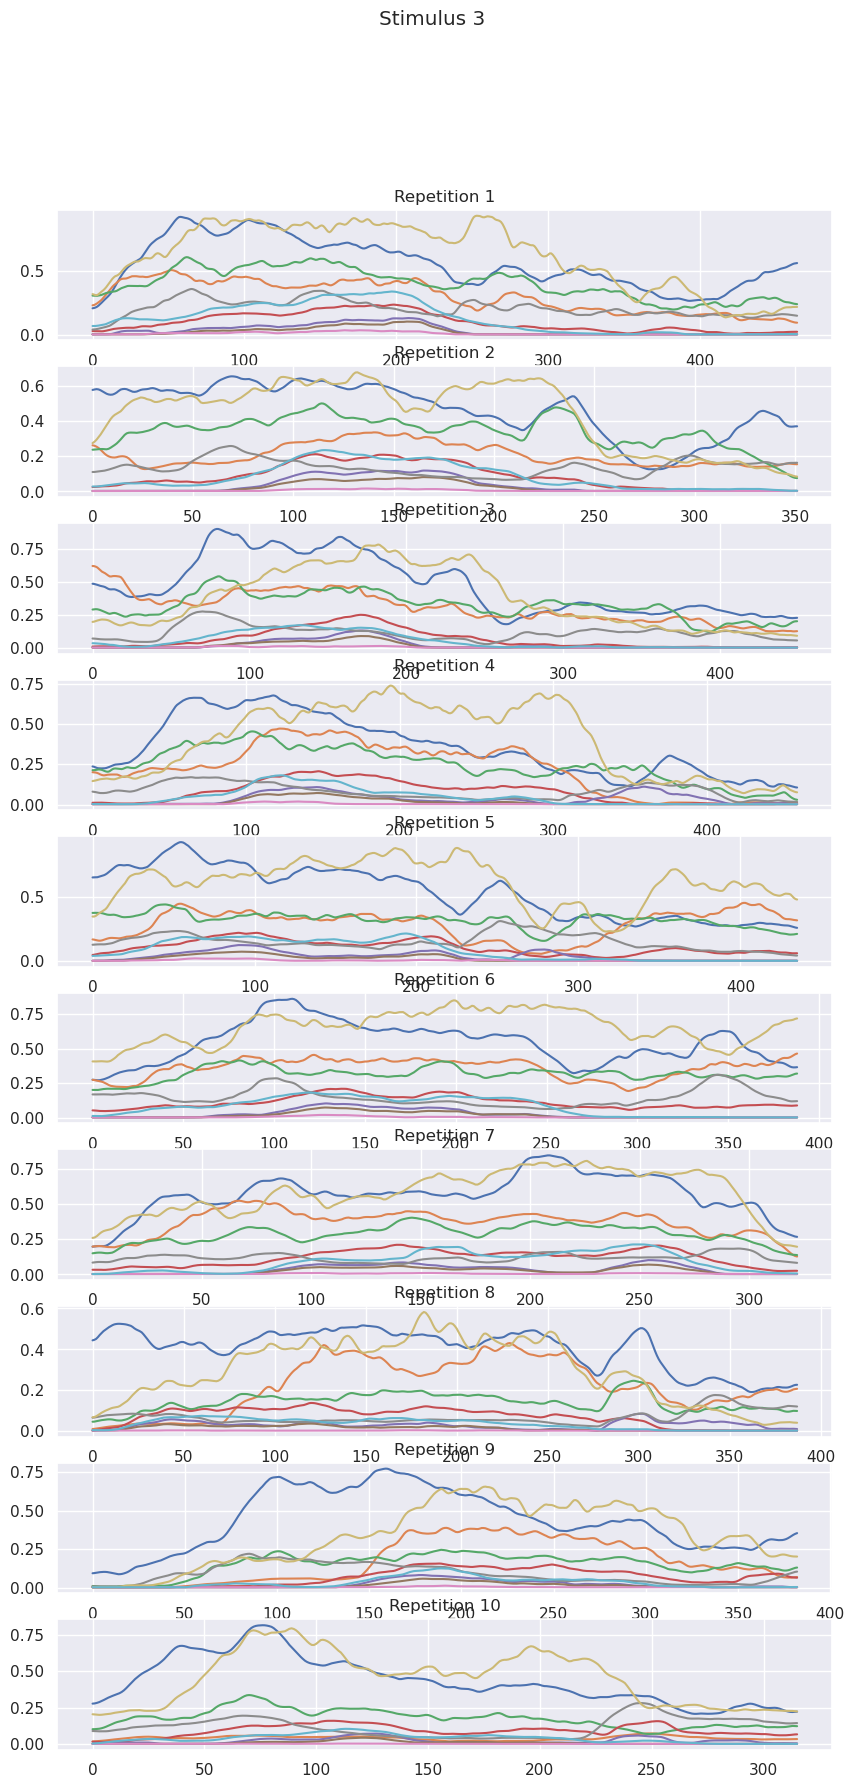

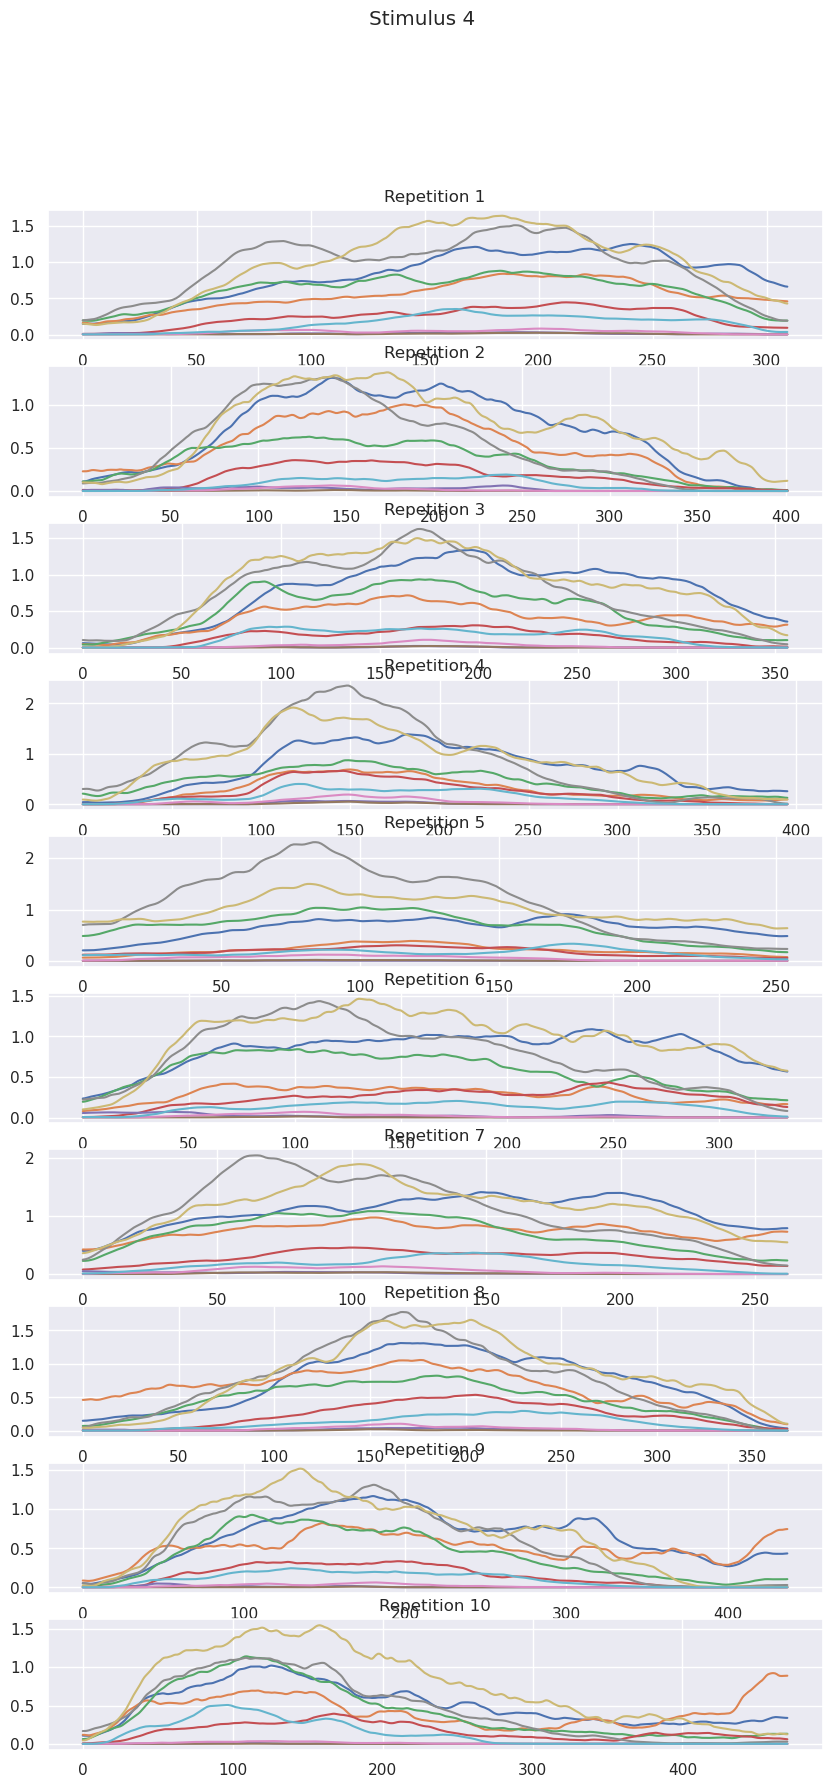

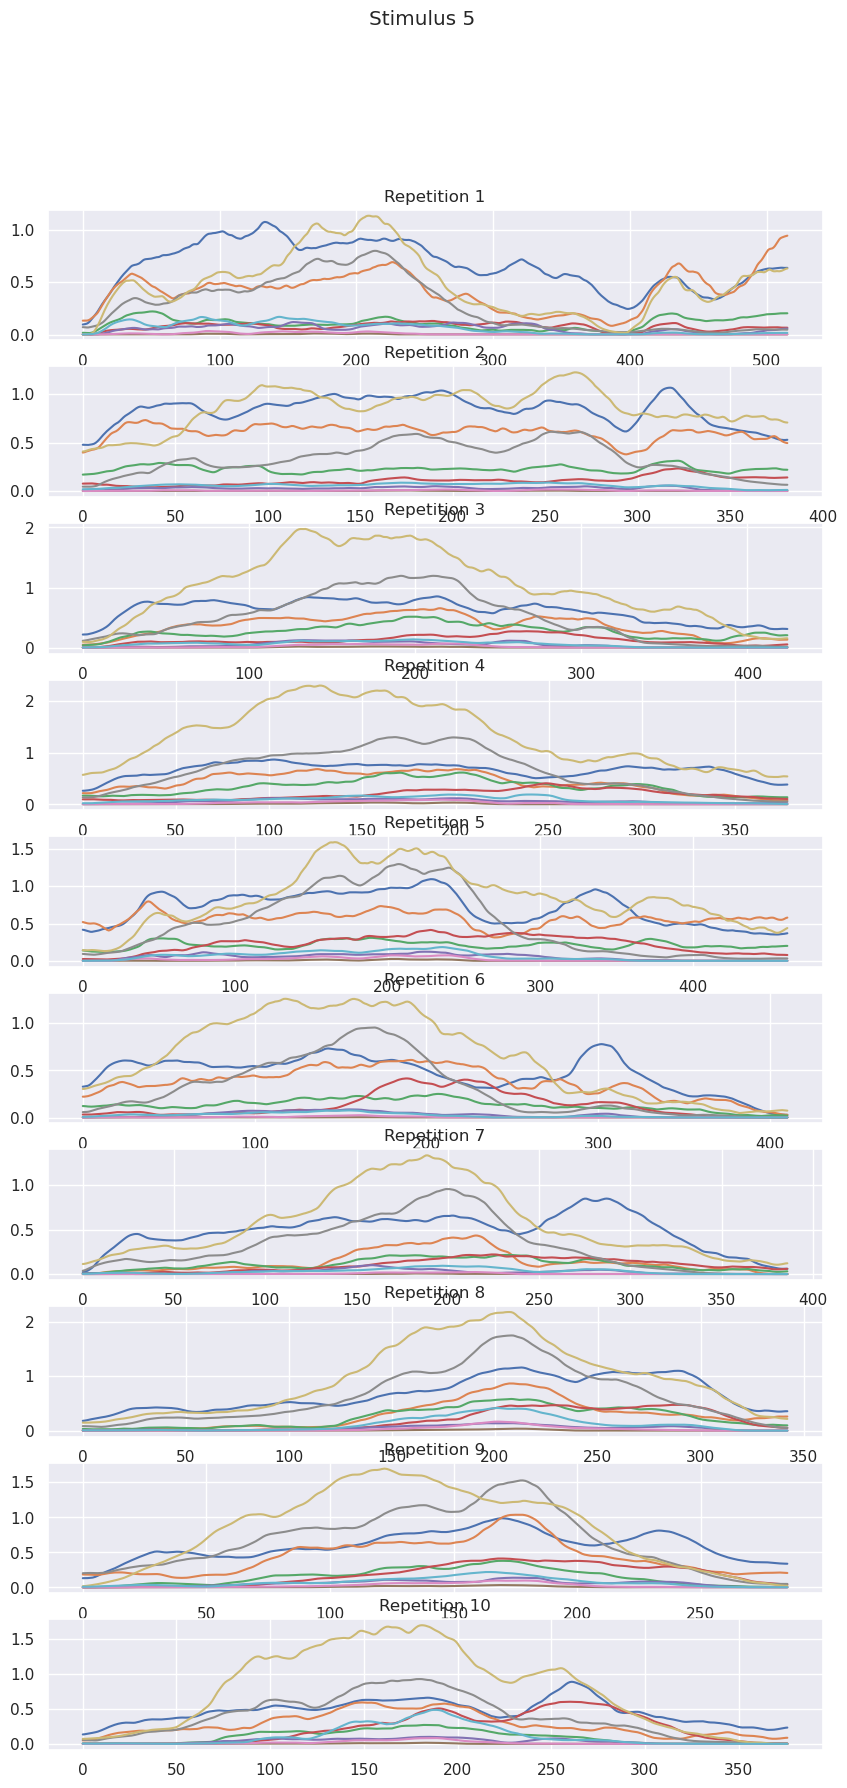

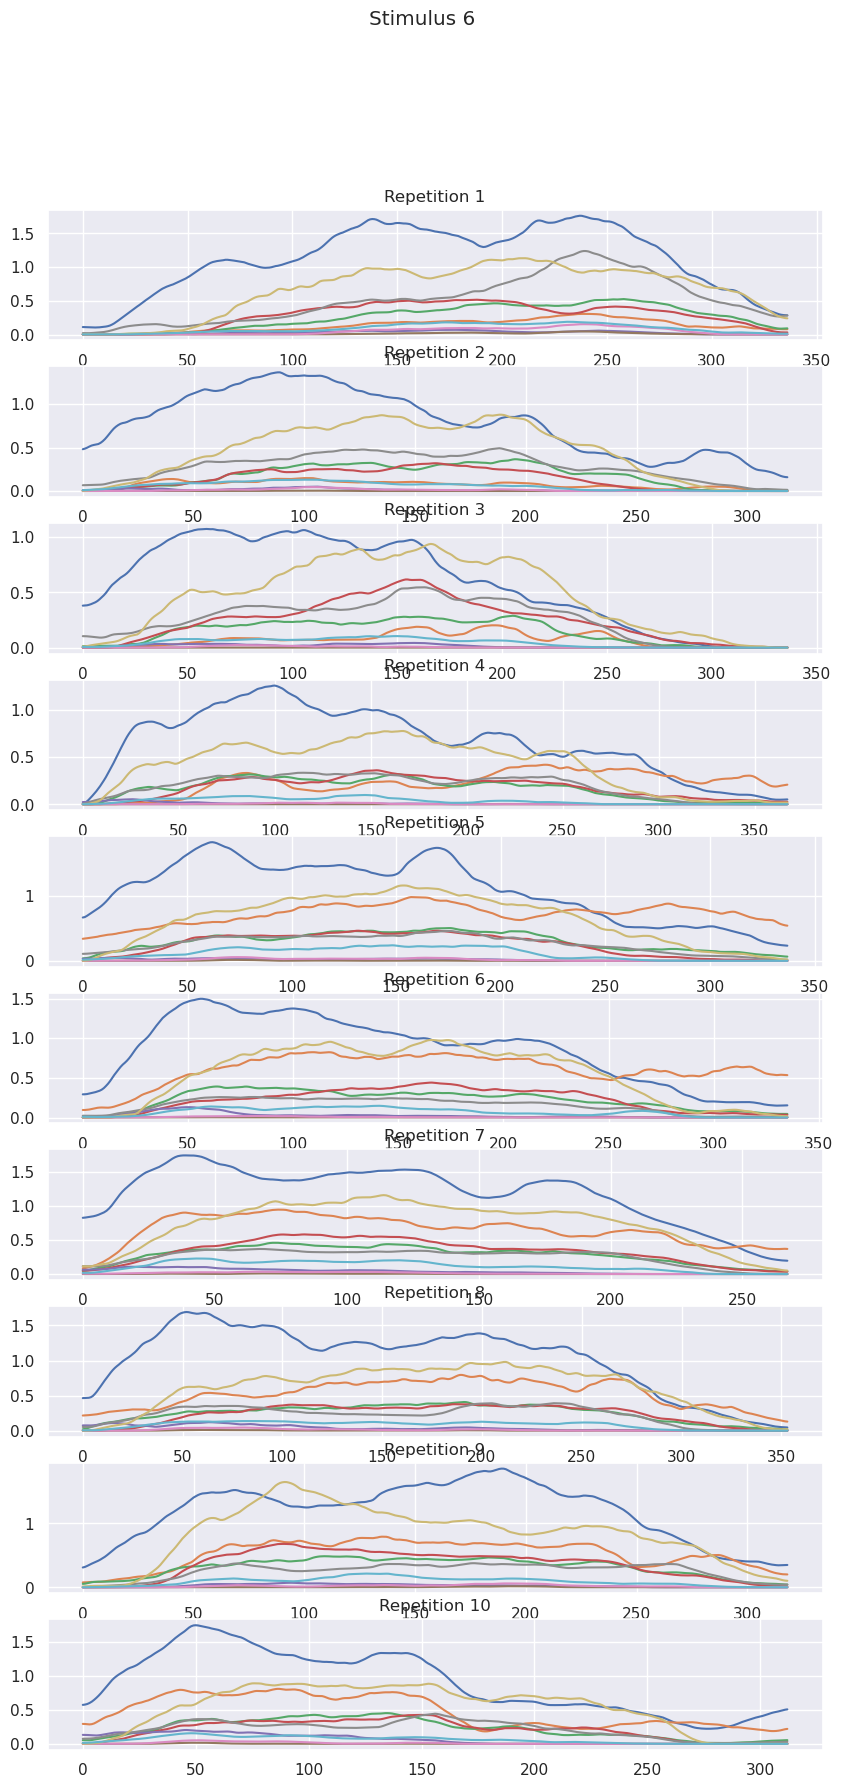

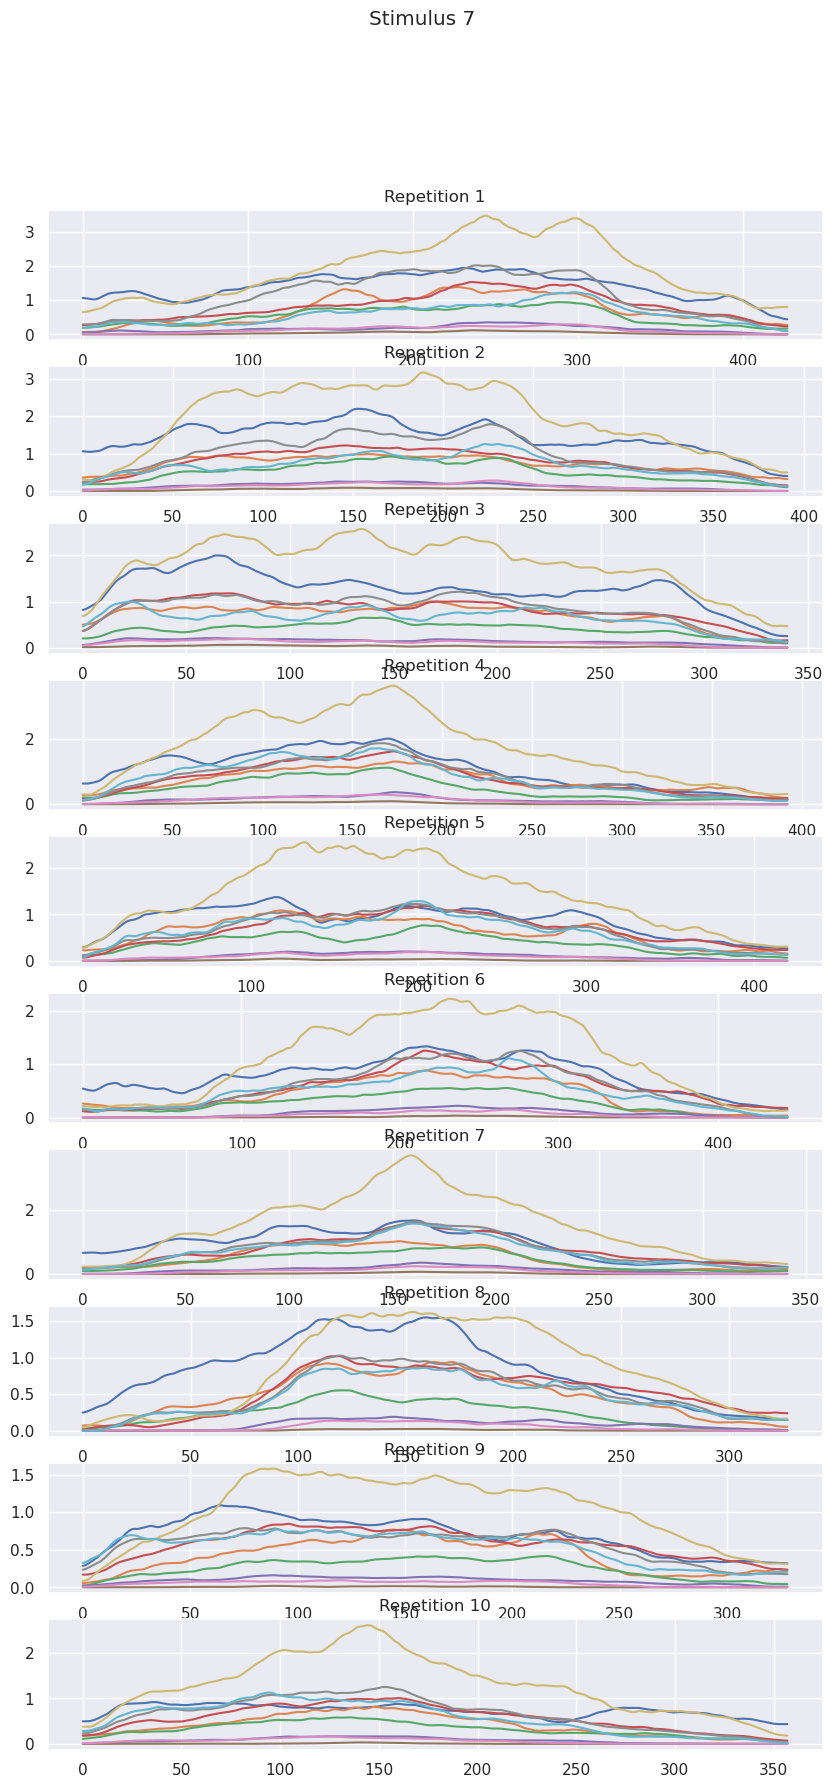

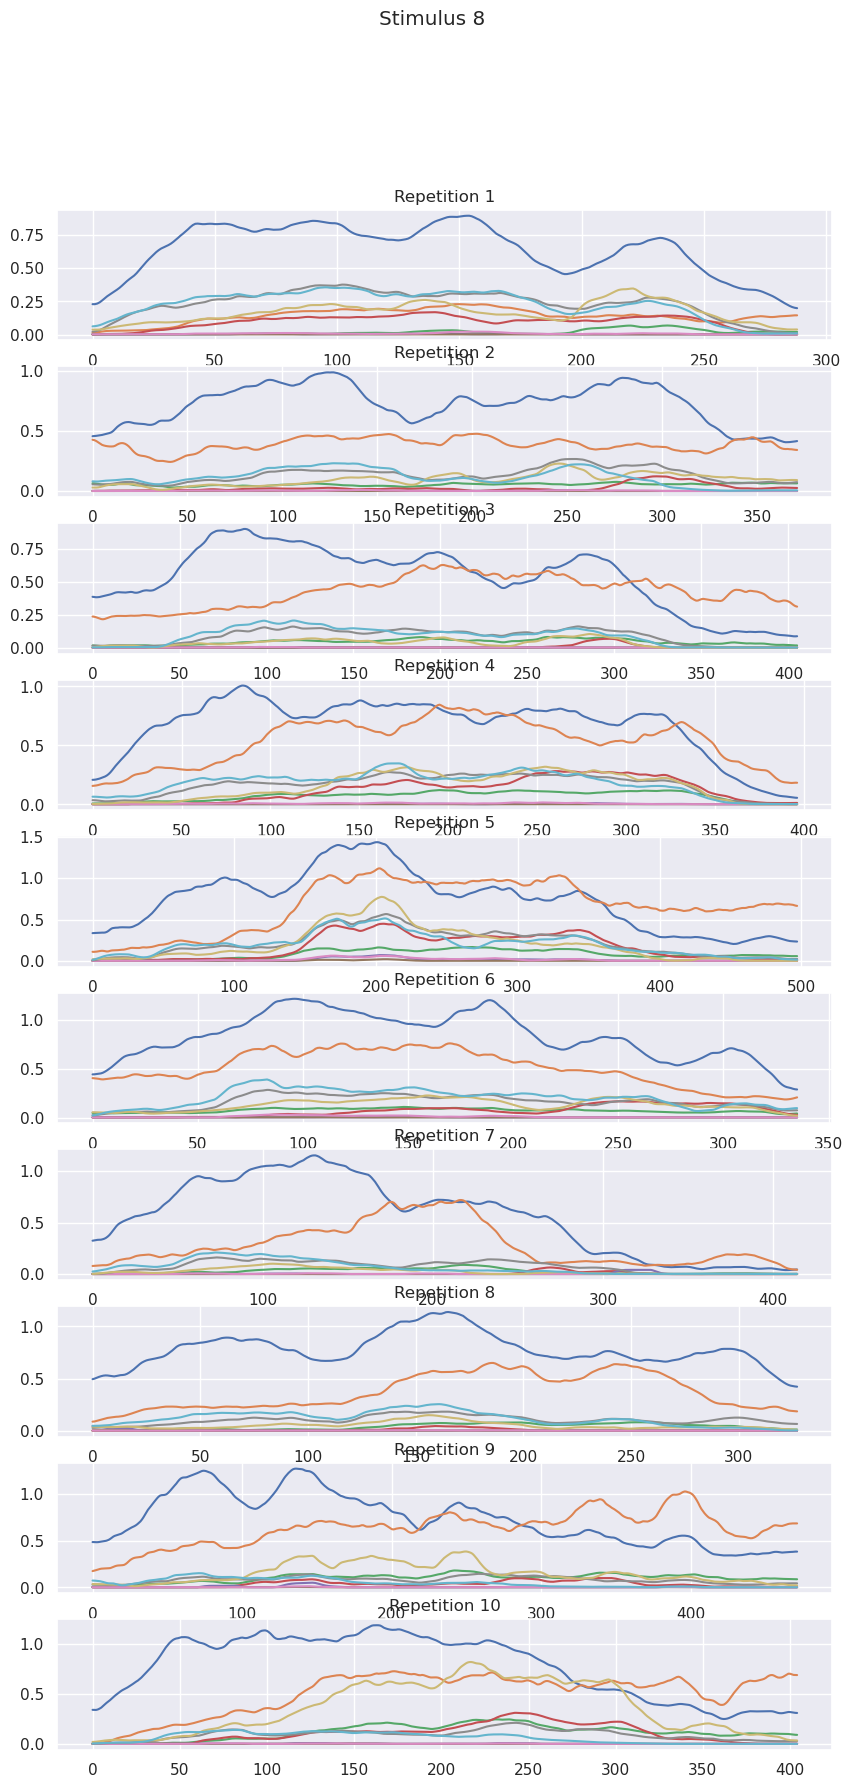

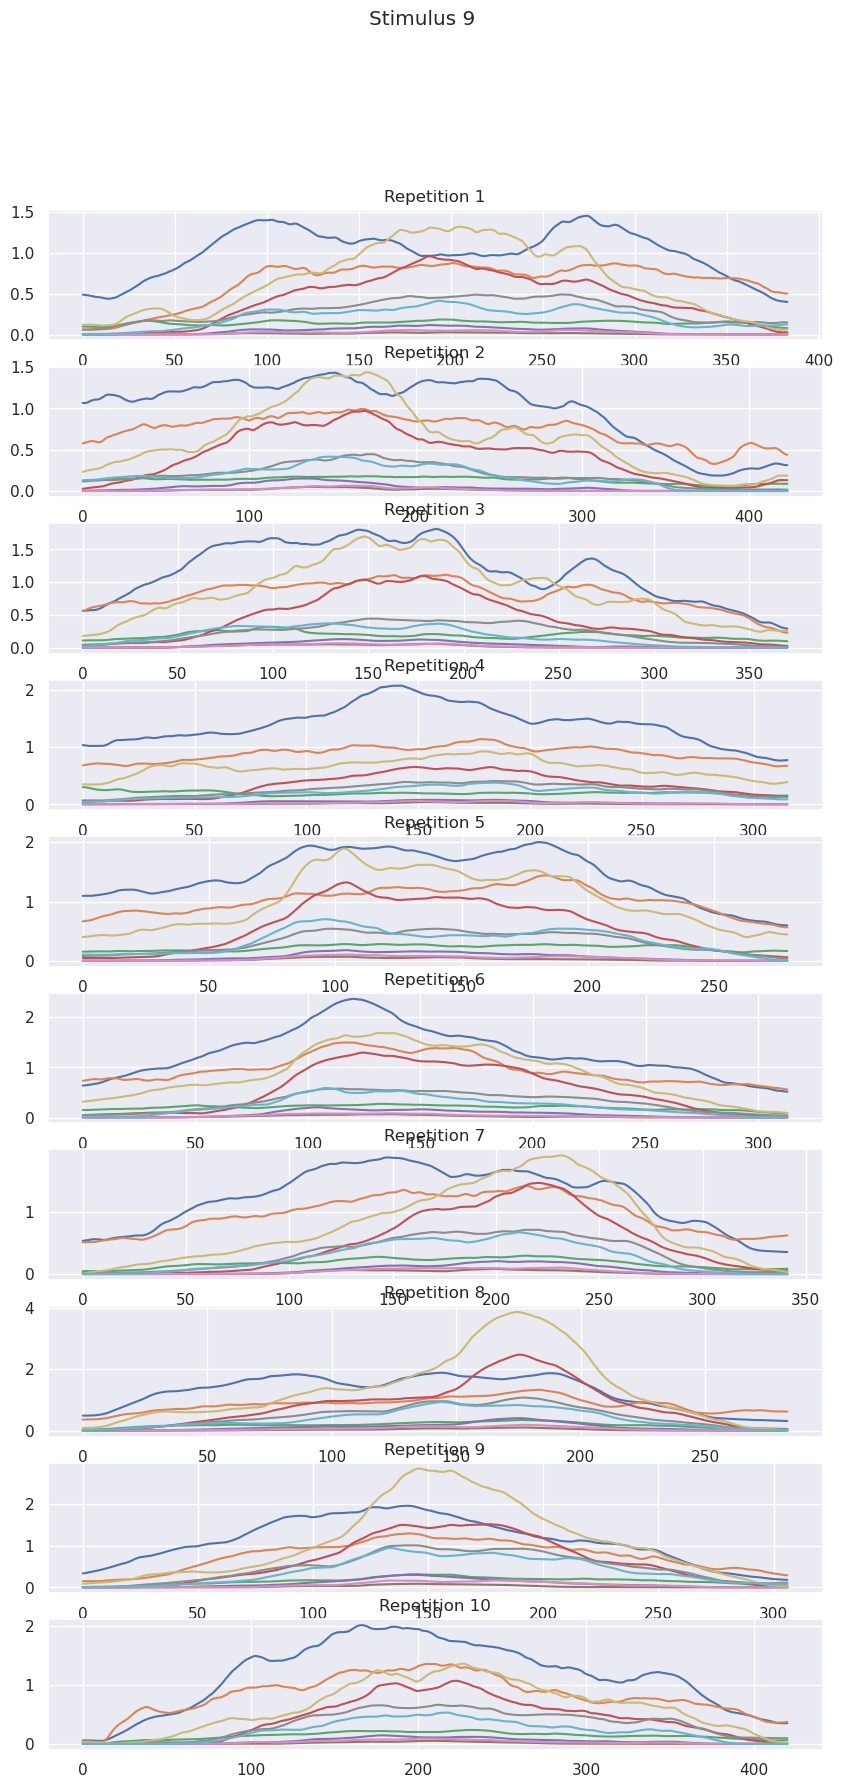

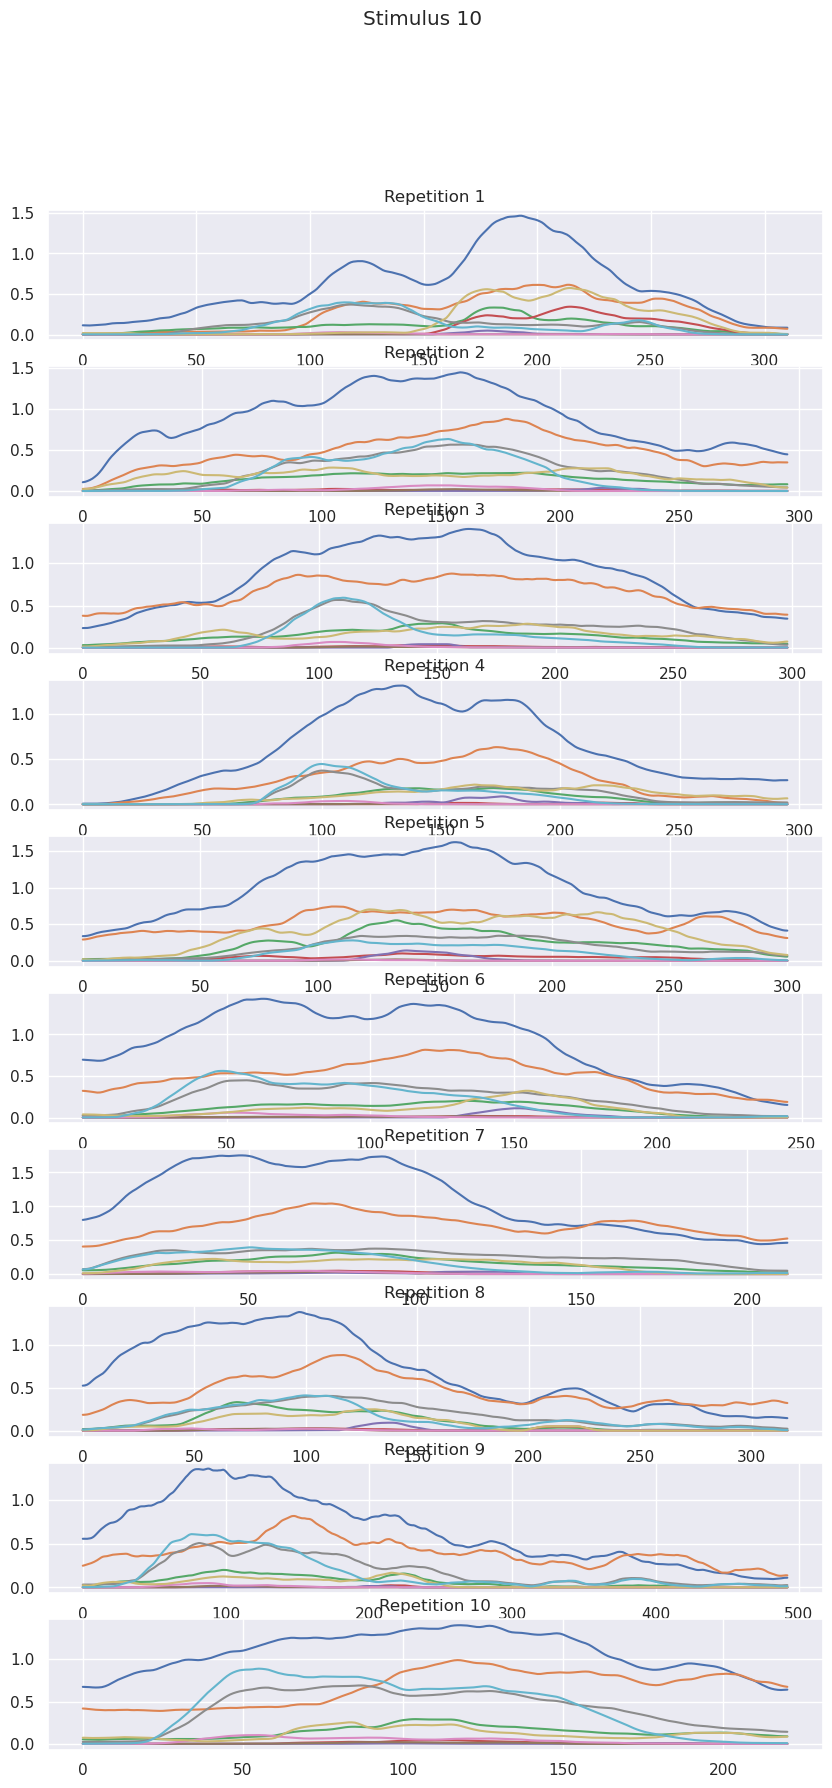

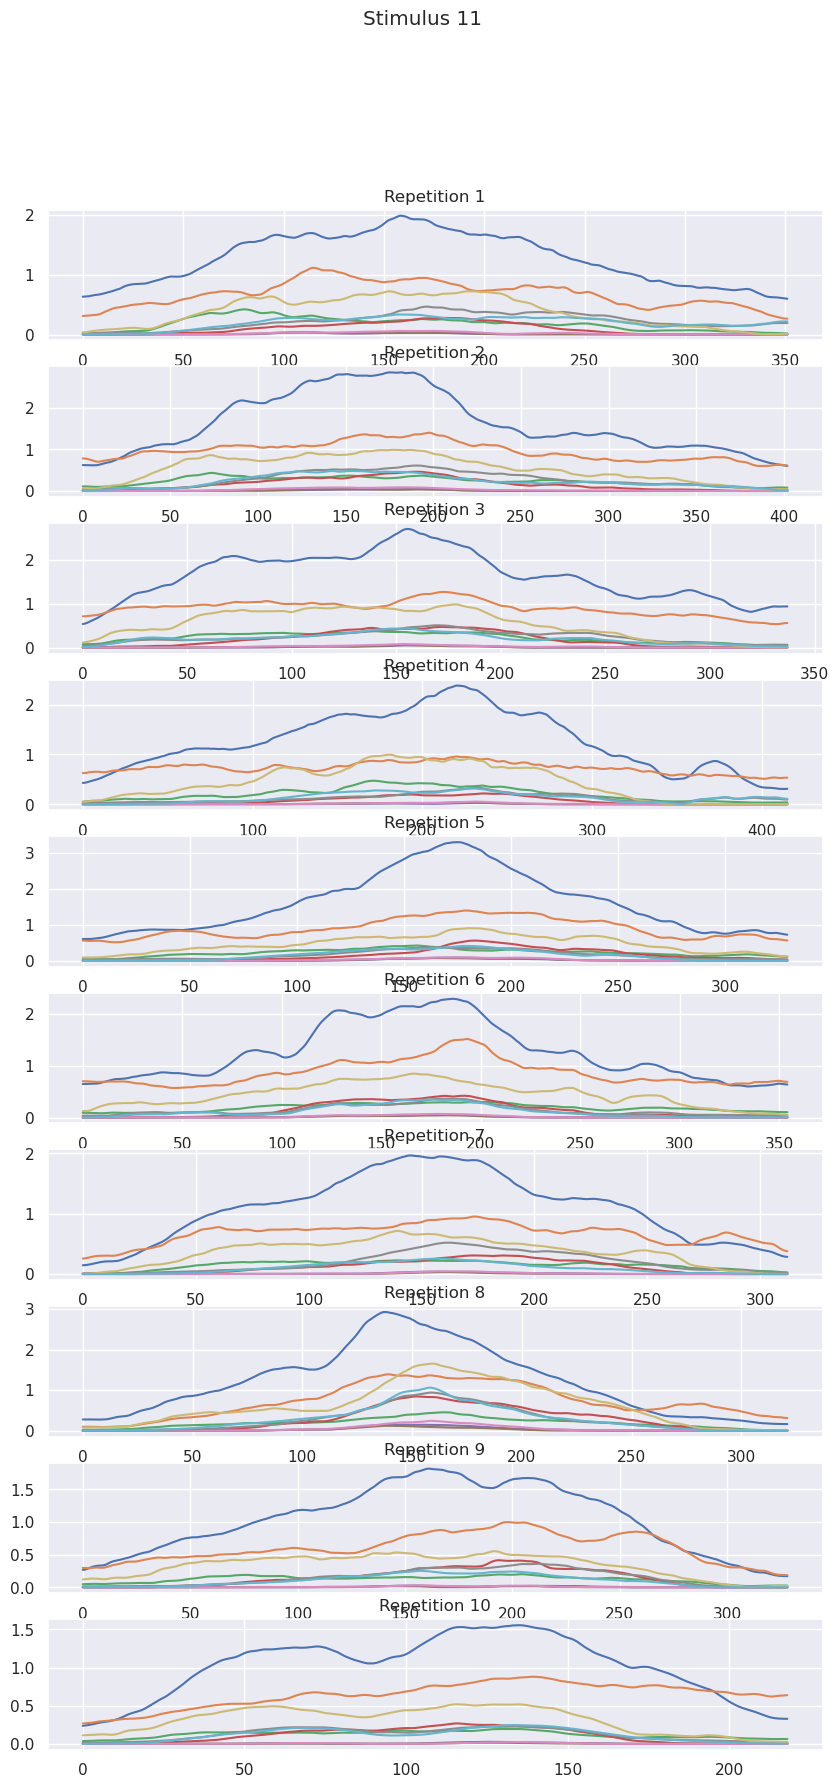

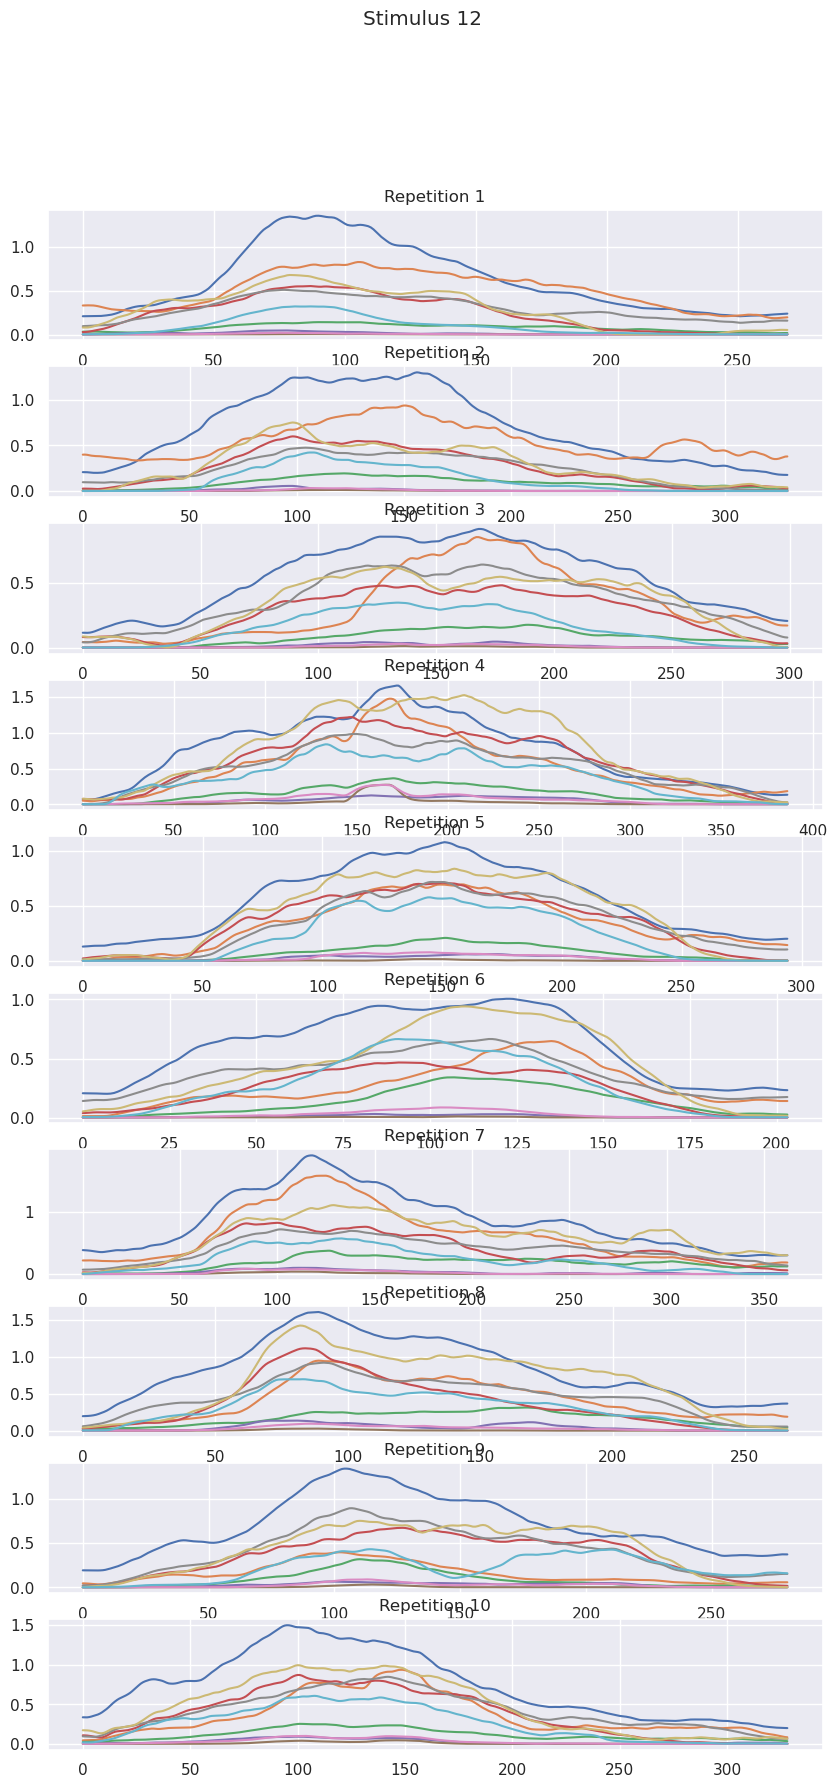

In [35]:
for s in range(n_stimuli):
    fig, ax = plt.subplots(n_repetitions, 1, figsize=(10, 2*n_repetitions))
    fig.suptitle(f"Stimulus {s+1}")
    for r in range(n_repetitions):
        ax[r].plot(emg_envelopes[s][r])
        ax[r].set_title(f"Repetition {r+1}")
